Repeat the analysis for MercuryErrorLog.txt and BGLErrorLog.txt:
1. tuple count plot + selected CWIN;
2. grouping the entries with CWIN;
3. empirical distributions;
4. fit the empirical reliability (exponential model + other tentative distributions,
e.g., weibull);
5. analysis of the fit via the K-S test;

**COMPARE RESULTS ACROSS THE SYSTEMS!**

Conduct the analysis to answer the following questions:
1. can the same coalesce windows be used across different nodes (Mercury,
BG/L) and error categories (Mercury) ?
2. what about the relationship between the system reliability and nodes
reliability?
3. there exist dependability-bottlenecks (i.e., top-contributors to the total
number of failures)?
4. do similar functional nodes (e.g., two Mercury tg-cX computing nodes
or BG/L I/O nodes Ri:Mx:Nz) exhibit similar reliability parameters?
5. there exist a relationship between the error types and the node (Mercury)?
6. Whatever additional considerations and results!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
import os
import sys
import shutil
import re
import pandas as pd
import csv
logfile_Mercury = '/content/MercuryErrorLog.txt'
logfile_BlueGene = '/content/BGLErrorLog.txt'

#1)Metodo Analisi Sensitività

In [2]:
def Selezione_finestra_temporale(logfile, Finestra_Temporale):
    try:
        with open(logfile, 'rt') as file:
            lines = file.readlines()
            timestamps = [float(line.split()[0]) for line in lines]
    except FileNotFoundError:
        print('Impossibile aprire il file')
        return
    i = 1
    tcount = 1
    prev = timestamps[0]
    while i < len(timestamps):
        succ = timestamps[i]
        delta = succ - prev

        if delta < Finestra_Temporale:
            j = 0
        else:
            tcount += 1
        prev = succ
        i += 1
    return tcount

def sensitivity_analysis(logfile, W):
    results = []
    for Finestra_Temporale_value in W:
        result = Selezione_finestra_temporale(logfile, Finestra_Temporale_value)
        results.append(result)
    return results

def plot_sensitivity_analysis(W, results,stato, title='Analisi di Sensibilità di Finestra_Temporale'):
  plt.plot(W, results, marker='o')
  plt.title(title)
  plt.xlabel('Valore di Finestra_Temporale')
  plt.ylabel('Numero di Tuple')
  plt.grid(True)
  if stato==0:
    plt.ylim(0, max(results)+100)  # Imposta l'intervallo dell'asse y
    plt.xlim(0, 500)  # Imposta l'intervallo dell'asse x (esempio: da 0 a 100)
  else:
     plt.ylim(300,700)  # Imposta l'intervallo dell'asse y
     plt.xlim(0, 500)  # Imposta l'intervallo dell'asse x (esempio: da 0 a 100)

  plt.show()

def plot_sensitivity_analysis_2(W, results,stato,color):
  plt.plot(W, results, color = color)
  plt.xlabel('Valore di Finestra_Temporale')
  plt.ylabel('Numero di Tuple')
  plt.grid(True, linestyle='--', alpha=0.7)
  plt.gca().set_facecolor('#f0f0f0')

#2)Stima Numero Tuple in funzione del Cwin

In [3]:
def estimate_tuple_count(logfile_path, cwin):
    # Open the log file
    logfiled = open(logfile_path, "r")
    loglines = logfiled.readlines()
    # Initialize tuple count
    tcount = 1
    i = 0
    line = loglines[i].split()
    prev = line[0]

    i = i + 1
    while i < len(loglines):
        line = loglines[i].split()
        succ = line[0]

        # Calculate delta
        delta = int(succ) - int(prev)

        # Check if delta is less than cwin
        if int(delta) < int(cwin):
            j = 0
        else:
            tcount = int(tcount) + 1

        prev = succ
        i = i + 1

    # Return the tuple count
    return cwin, tcount

#3)Ragruppare le tuple generate in un unico file CSV

In [4]:
def process_content(content, csv_writer, counter):
    lines = content.strip().split('\n')

    for line in lines:
        parts = line.split(' ')
        timestamp = parts[0]
        node = parts[1]
        subsystem = parts[2]
        message = ' '.join(parts[3:])

        csv_writer.writerow({
            'Timestamp': timestamp,
            'Node': node,
            'Subsystem': subsystem,
            'Message': message,
            'Tupla': counter
        })

def create_csv(input_file, output_file,counter):
    with open(input_file, 'r') as file:
        file_content = file.read()

    with open(output_file, 'a', newline='') as csvfile:
        fieldnames = ['Timestamp', 'Node', 'Subsystem', 'Message', 'Tupla']
        csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        csv_writer.writeheader()
        process_content(file_content, csv_writer, counter)

#4)Processo LogFile,con creazione di tuple e relativi file per l'analisi

In [5]:

def process_log_file(logfile_path, cwinsize,Label):
    # Read the log file, creating a list of strings in loglines
    logfiled = open(logfile_path, "r")
    loglines = logfiled.readlines()

    # Initialize variables
    line = loglines[0].split()
    prev = line[0]
    tcount = 1

    # Create a directory to store tuple results
    directory = Label+"_" + str(cwinsize) + "tupling"
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Open files for writing interarrivals, lengths, and startingPoints
    finterarrivals = open(Label+'_interarrivals.txt', 'w')
    flengths = open(Label+'_lengths.txt', 'w')
    fstartingPoints = open(Label+'_startingPoints.txt', 'w')

    i = 0
    j = 0

    # Write the first log entry to the first tuple
    f = open(directory + '/tuple' + str(tcount) + '.txt', 'w')
    f.write(loglines[i])

    i = i + 1

    # Iterate through all log entries
    while i < len(loglines):
        line = loglines[i].split()
        succ = line[0]
        delta = int(succ) - int(prev)

        if int(delta) < int(cwinsize):
            j = j + 1
            f.write(loglines[i])
        else:
            # Complete the current tuple and create a new one
            diff_time = int(loglines[i - 1].split()[0]) - int(loglines[i - j - 1].split()[0])
            flengths.write(str(diff_time) + '\n')
            fstartingPoints.write(str(int(loglines[i - j - 1].split()[0])) + ' ' + str(diff_time) + '\n')
            finterarrivals.write(str(delta) + '\n')
            f.close()

            # Create the next tuple
            j = 0
            tcount = int(tcount) + 1
            f = open(directory + '/tuple' + str(tcount) + '.txt', 'w')
            f.write(loglines[i])

        prev = succ
        i = i + 1

    # Close files
    fstartingPoints.close()
    flengths.close()
    finterarrivals.close()
    f.close()




#5)Calcolo Collisioni

In [6]:
import os
from prettytable import PrettyTable

def process_tuples(directory, error_log_file, num_files, label):
    # Scrivo l'intestazione
    prefisso = "tuple"
    estensione = ".txt"
    output_file = label + "_output.txt"
    collisions_file = label + "_collisioni.txt"

    with open(output_file, "w") as f:
        f.write("file #elem startingPoint length interarrivo result \n")

    # Apro un file in scrittura per collezionare i risultati delle possibili collisioni
    with open(collisions_file, "w") as fcollisioni:
        # Create a PrettyTable for collisions
        collisions_table = PrettyTable()
        collisions_table.field_names = ["Tuple", "Number of Collisions"]

        prec = 0

        # Ottengo la lista dei file nella cartella
        onlyfiles = [f"{prefisso}{i}{estensione}" for i in range(1, num_files + 1)]

        # Per ogni tupla
        for namefile in onlyfiles:
            # Leggo la tupla
            with open(os.path.join(directory, namefile), "r") as logfiled:
                loglines = logfiled.readlines()

            # Scrivo le statistiche summary sul file di output
            with open(output_file, "a") as f:
                f.write(namefile + " ")
                f.write(str(len(loglines)) + " ")
                f.write(loglines[0].split()[0] + " ")
                f.write(str(int(loglines[len(loglines) - 1].split()[0]) - int(loglines[0].split()[0])) + " ")
                f.write(str(int(loglines[0].split()[0]) - prec) + " ")

                countList = []
                valuesList = []
                for i in range(1, 3):
                    count = {}
                    values = set(map(lambda x: x.split()[i], loglines))
                    for x in values:
                        for y in loglines:
                            if y.split()[i] == x:
                                if x not in count:
                                    count[x] = 1
                                else:
                                    count[x] = count[x] + 1
                    countList.append(count)
                    valuesList.append(values)

                f.write(str(countList[0]) + " ")
                f.write(str(countList[1]) + " ")
                f.write("\n")

            prec = int(loglines[len(loglines) - 1].split()[0])

            coll = []
            tup = []

            # Mi occupo delle collisioni
            if len(valuesList[0]) > 1:
                fcollisioni.write(namefile + " -> " + str(len(valuesList[0])) + "\n")
                print(namefile + " " + str(len(valuesList[0])) + "\n")
                # Add information to PrettyTable
                collisions_table.add_row([namefile, len(valuesList[0])])

        # Print the collisions table
        #print("Collisions Summary:")
        #print(collisions_table)


#6)Analisi Troncamento

In [7]:
def TruncationsAnalysis(file_path):
    trunc_countLog = 0
    nodiLog = pd.read_csv(file_path)

    # Get unique values in the 'Tupla' column
    istanzeLog = nodiLog[nodiLog['Tupla'] != 'Tupla']['Tupla'].unique()

    # Create a dictionary to store truncation counts for each node
    truncation_counts = {}

    # Iterate over the unique values
    for i in range(len(istanzeLog) - 1):
        t = istanzeLog[i]
        t_next = istanzeLog[i + 1]

        mask = (nodiLog['Tupla'] == t)
        mask_next = (nodiLog['Tupla'] == t_next)

        istanze_filtrate = nodiLog.loc[mask]
        istanze_filtrate_next = nodiLog.loc[mask_next]

        if (istanze_filtrate.iloc[-1]['Node'] == istanze_filtrate_next.iloc[0]['Node']):
            trunc_countLog += 1
            node = istanze_filtrate.iloc[-1]['Node']
            print(f'Troncamento: tupla {t} - tupla {t_next} --- Nodo: {node}')

            # Update the truncation count for the current node
            if node in truncation_counts:
                truncation_counts[node] += 1
            else:
                truncation_counts[node] = 1

    # Plotting with vertical text on y-axis
    nodes = list(truncation_counts.keys())
    counts = list(truncation_counts.values())

    print('Troncamenti: ' + str(trunc_countLog))
    print('Percentuale di troncamenti: ' + str(trunc_countLog / len(istanzeLog) * 100) + ' %')

    plt.bar(nodes, counts)
    plt.xlabel('Nodo')
    plt.ylabel('Numero di Troncamenti')
    plt.title('Truncations Analysis per Nodo')
    plt.xticks(rotation='vertical')  # Rotate the x-axis labels vertically
    plt.savefig('TruncationsAnalysis')
    plt.show()
    nodes.clear()
    counts.clear()

#7)Ploat TTF & CDF Realibility

In [8]:
def plot_empirical_ttf_reliability(interarrivals_file):
    # Load interarrivals.txt
    interarrivals = np.loadtxt(interarrivals_file)

    # Function to calculate cumulative distribution function (CDF)
    def cdfcalc(data):
        sorted_data = np.sort(data)
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        return cdf, sorted_data

    # Calculate empirical TTF and reliability
    y_CDF, ttf = cdfcalc(interarrivals)
    emp_TTF = y_CDF[:len(ttf)]  # Ensure emp_TTF and ttf have the same length
    emp_REL = 1 - emp_TTF

    # Plotting
    plt.figure()
    plt.plot(ttf, emp_TTF, '-*b', label='empTTF')
    plt.plot(ttf, emp_REL, '-+r', label='empREL')
    plt.xlabel("Time (s)")
    plt.ylabel("p")

    # Express the time axis with scientific notation (10^5)
    plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=True, useOffset=False))
    plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0), useMathText=True)

    plt.legend()
    plt.show()

#8)Statics Log File

In [9]:
import matplotlib.pyplot as plt

def statistics_log_file(logfile_path):
    # Read the log file, creating a list of strings in loglines
    with open(logfile_path, "r") as logfiled:
        loglines = logfiled.readlines()

    # Print the number of lines in the log
    print("== Total error entries ==")
    print(len(loglines))

    # Declare a function 'pretty' to print a dictionary 'd' in a user-friendly way
    # It returns a list starting from the dictionary 'd'
    def pretty(d):
        lista = []
        for key, value in sorted(d.items(), key=lambda d: -d[1]):
            lista.append(key + " -> " + str(value))
        return lista

    # Indicate, for each node (i=1) and for each category (i=2), the number of entries in the log file
    for i in range(1, 3):
        count = {}
        # 'values' contains all nodes (i=1) and all categories (i=2) in the log file
        # The map function associates each element of 'loglines' (all tuples) with its corresponding node (i=1) or category (i=2)
        # The 'set' function ensures that each element appears only once
        values = set(map(lambda x: x.split()[i], loglines))
        for x in values:
            # For each log entry
            for y in loglines:
                # If the current log entry was generated by node x (i=1) or belongs to category x (i=2)
                if y.split()[i] == x:
                    # If it is the first element, initialize the count for that node (i=1) or category (i=2)
                    if x not in count:
                        count[x] = 1
                    # Increment the count
                    else:
                        count[x] = count[x] + 1

        # Print the output for nodes
        if i == 1:
            count1 = dict(sorted(count.items(), key=lambda item: item[1], reverse=True)[:10])
            print("== Breakup by NODE* ==")
            print(pretty(count1))
            print("* only the top 10 most occurring nodes are reported")

            # Plot Breakup by NODE with legend
            plt.figure(figsize=(15, 8))
            for label, data in count1.items():
                plt.bar(label, data, label=label)
            plt.xlabel('Nodes')
            plt.ylabel('Number Of Entry')
            plt.title('Breakup by NODE')
            plt.legend()
            plt.show()

        # Print the output for categories
        elif i == 2:
            count2 = dict(sorted(count.items(), key=lambda item: item[1], reverse=True)[:10])
            print("== Breakup by CATEGORY ==")
            print(pretty(count2))

            # Plot Breakup by CATEGORY with legend
            if len(count2) > 1:  # Check if there is more than one element in Breakup by CATEGORY
                plt.figure(figsize=(15, 8))
                for label, data in count2.items():
                    plt.bar(label, data, label=label)
                plt.xlabel('Categories')
                plt.ylabel('Number Of Entry')
                plt.title('Breakup by CATEGORY')
                plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
                plt.legend()
                plt.show()

#9)Suddivisione in base ai nodi

In [10]:
def divide_log_by_nodes(input_file, output_folder, node_files):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Open files dynamically based on the node names
    file_handles = {node: open(os.path.join(output_folder, filename), 'wt') for node, filename in node_files.items()}

    with open(input_file, 'rt') as fid:
        for linea in fid:
            aline = linea.split()
            node_name = aline[1]

            if node_name in file_handles:
                file_handles[node_name].write(linea)

    # Close all file handles
    for file_handle in file_handles.values():
        file_handle.close()

#10)Suddivisione in base alla tipologia di errore

In [11]:
def split_log_by_error_category(logfile_path, output_folder):
    # Read the log file, creating a list of strings in loglines
    with open(logfile_path, "r") as logfiled:
        loglines = logfiled.readlines()

    # Initialize a dictionary to count the number of entries for each error category
    error_counts = {}

    # Create a folder for the log files
    os.makedirs(output_folder, exist_ok=True)

    # Initialize the variable for the error log file name
    error_log_filename = ""

    # For each log entry
    for j, log_entry in enumerate(loglines):
        # Get the error category
        error_category = log_entry.split()[2]

        # Increment the count for the error category
        error_counts[error_category] = error_counts.get(error_category, 0) + 1

        # Create the error log file name
        error_log_filename = os.path.join(output_folder, f"{error_category}_error_log.txt")

        # Write the log entry to the corresponding error log file
        with open(error_log_filename, "a") as error_log_file:
            error_log_file.write(log_entry)






#11)Calcolo Intearrivals nodi significativi

In [12]:
def create_interarrivals_file(logfile_path, cwinsize,label,label1):

    output_directory=label1+"IntarrNode"
    # Read the log file, creating a list of strings in loglines
    with open(logfile_path, "r") as logfiled:
        loglines = logfiled.readlines()

    # line is a list containing various strings obtained by splitting the current entry with the space character
    line = loglines[0].split()
    # prev contains the timestamp of the first log entry
    prev = line[0]

    # If the directory doesn't exist, create it to collect all resulting tuples
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Count of the number of tuples created
    tcount = 1

    # Create a file in writing to save interarrivals
    finterarrivals = open(os.path.join(output_directory, label+'_intarr.txt'), 'w')

    i = 1  # Starting from 1 since the first log entry has already been considered
    j = 0

    # Iterate through all log entries
    while i < len(loglines):
        line = loglines[i].split()
        # succ contains the timestamp of the current log entry
        succ = line[0]

        # Calculate delta, i.e., the difference between the timestamp of the current log entry and the timestamp of the previous log entry
        delta = int(succ) - int(prev)

        # If delta is less than the chosen window size
        if int(delta) < int(cwinsize):
            j = j + 1
            # Write the current log entry to the current tuple

        else:
            # If in this branch, conclude the current tuple and create the next tuple
            # Conclude the current tuple

            # Write the interarrival of the current tuple
            finterarrivals.write(str(delta) + '\n')
            # Close the file of the current tuple

            # Create the next tuple
            # Initialize the number of log entries in the new tuple
            j = 0
            # Increment the count of created tuples
            tcount = int(tcount) + 1
            # Open a file in writing to collect the results of tuple tcount

        # The timestamp of the current log entry becomes the timestamp of the previous log entry (prepare for a new iteration)
        prev = succ
        i = i + 1

    # Close the files
    finterarrivals.close()

#12)Plottaggio realibility nodi significativi insieme alla realibility tot del sistema

In [13]:
def plotComp_empirical_ttf_reliability(interarrivals_data, labels=None, xlim=None):
    # Function to calculate cumulative distribution function (CDF)
    def cdfcalc(data):
        sorted_data = np.sort(data)
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        return cdf, sorted_data

    # Plotting
    plt.figure()

    for i, interarrivals in enumerate(interarrivals_data):
        y_CDF, ttf = cdfcalc(interarrivals)
        emp_TTF = y_CDF[:len(ttf)]  # Ensure emp_TTF and ttf have the same length
        emp_REL = 1 - emp_TTF
        label = labels[i] if labels else f'Dataset {i + 1}'
        plt.plot(ttf, emp_REL, label=label)

    plt.xlabel("Time (s)")
    plt.ylabel("p")

    # Express the time axis with scientific notation (10^5)
    plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=True, useOffset=False))
    plt.ticklabel_format(axis='x', style='sci', scilimits=(0, 0), useMathText=True)

    # Set x-axis limits if specified
    if xlim:
        plt.xlim(xlim)

    plt.legend()
    plt.show()

    return emp_REL



#1.Analisi Mercury





**Scelta della coalescence window e creazione delle tuple**




I dati che ci sono stati forniti sono già stati filtrati; ci troviamo quindi nel campo della **manipolazione** dei dati. La prima operazione da compiere è la coalescenza temporale, o tupling, il cui obiettivo è individuare dati con relazioni temporali. Il nostro primo obiettivo è scegliere il valore appropriato di W, poiché se questo valore è troppo piccolo si verificano fenomeni di troncamento, cioè più voci vengono distribuite su più tuple, mentre se W è troppo grande si possono verificare collisioni, ossia le voci non vengono inserite nelle tuple corrette, generando vari fallimenti. Di seguito possiamo osservare il grafico relativo all'analisi di sensibilità di Mercury

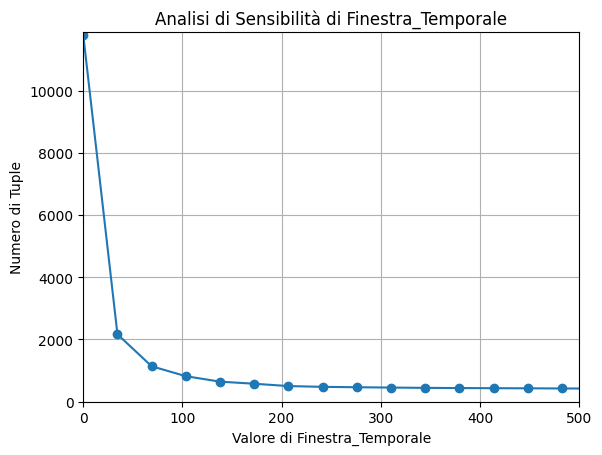

In [15]:
if __name__ == "__main__":
#1)AnalisiSensitività Mercury
  W = np.linspace(0.1, 1000, num=30)  # Genera 100 valori da 0.1 a 5000
  results = sensitivity_analysis(logfile_Mercury, W)
  plot_sensitivity_analysis(W, results,0)

è necessario selezionare un valore di Cwin appena a destra del "ginocchio". Viene scelto Cwin = 200, che corrisponde a 508 tuple. Di seguito sono riportati gli script per la stima del numero di tuple in base al Cwin scelto, la generazione delle tuple ed il calcolo relativo alle collisioni tra di esse.

In [16]:
#2) Stima tuple
cwin, tcount = estimate_tuple_count(logfile_Mercury,200)
print(f"Con un Cwin={cwin} posso generare {tcount} tuple")

Con un Cwin=200 posso generare 508 tuple


In [17]:
#3)Generazione Tuple
process_log_file(logfile_Mercury,cwin,"MercuryLog")


#3.1)Ragruppamento delle info di ogni singola tupla all'interno del file csv InfoSistemaMercury.csv

input_file = '/content/MercuryLog_200tupling'  # Sostituisci con il percorso effettivo del tuo file di input
output_file = '/content/InfoSistemaMercury.csv'
counter=1
prefisso = "tuple"
estensione = ".txt"
# Ottengo la lista dei file nella cartella
onlyfiles = [f"{prefisso}{i}{estensione}" for i in range(1,tcount)]
# Per ogni tupla
for namefile in onlyfiles:
            # Leggo la tupla
            dir=input_file+"/"+namefile
            create_csv(dir, output_file,counter)
            counter=counter+1

In [18]:
#4)Calcolo Collisioni
directory = '/content/MercuryLog_'+str(cwin)+'tupling'

process_tuples(directory,logfile_Mercury,tcount,"Mercury")

tuple8.txt 2

tuple15.txt 3

tuple26.txt 2

tuple29.txt 2

tuple37.txt 2

tuple50.txt 2

tuple69.txt 7

tuple74.txt 2

tuple77.txt 3

tuple114.txt 4

tuple116.txt 2

tuple117.txt 2

tuple123.txt 2

tuple127.txt 2

tuple135.txt 2

tuple144.txt 2

tuple166.txt 2

tuple167.txt 2

tuple171.txt 2

tuple186.txt 2

tuple196.txt 2

tuple298.txt 8

tuple299.txt 2

tuple302.txt 2

tuple305.txt 2

tuple315.txt 2

tuple317.txt 2

tuple318.txt 3

tuple325.txt 3

tuple326.txt 2

tuple331.txt 2

tuple332.txt 3

tuple334.txt 4

tuple335.txt 3

tuple339.txt 2

tuple370.txt 2

tuple377.txt 2

tuple397.txt 2

tuple402.txt 2

tuple412.txt 3

tuple414.txt 2

tuple424.txt 2

tuple429.txt 2

tuple459.txt 3

tuple477.txt 2

tuple502.txt 2

tuple507.txt 3



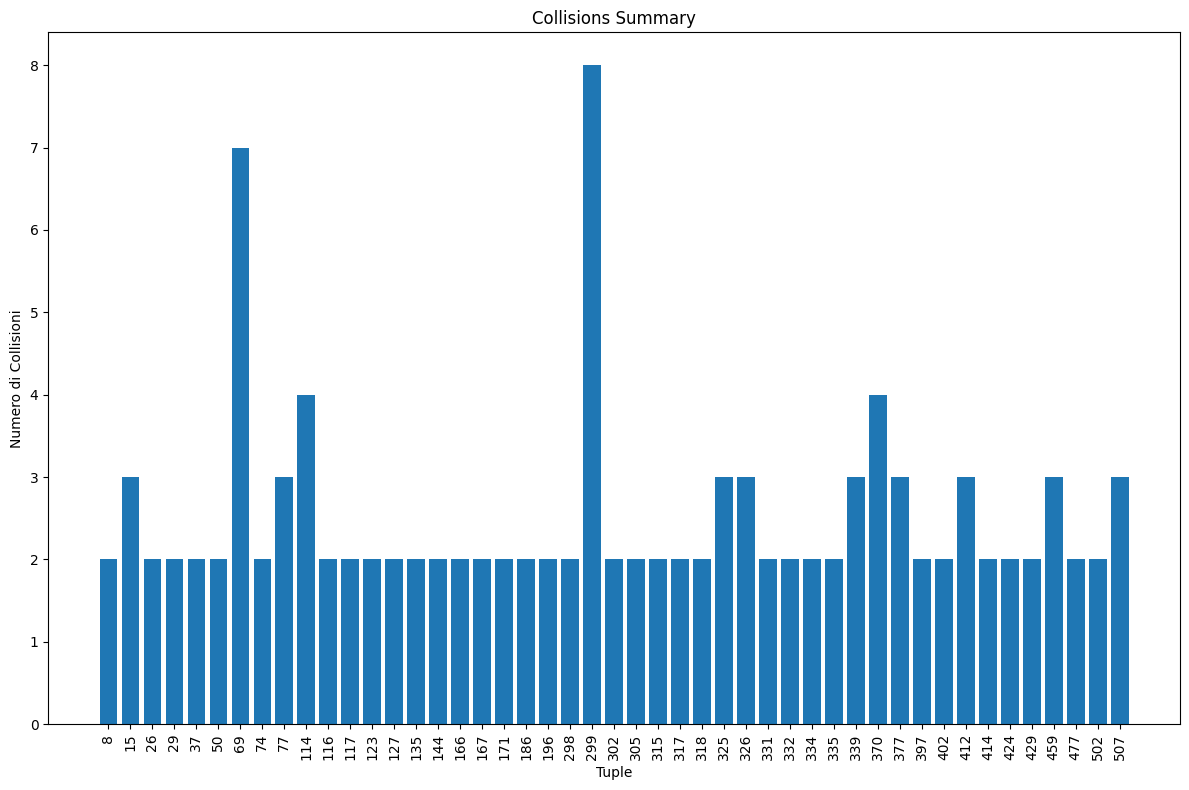

In [ ]:
# Dati della tabella
tuples = ["tuple8", "tuple15", "tuple26", "tuple29", "tuple37", "tuple50", "tuple69", "tuple74", "tuple77",
          "tuple114", "tuple116", "tuple117", "tuple123", "tuple127", "tuple135", "tuple144", "tuple166",
          "tuple167", "tuple171", "tuple186", "tuple196", "tuple298", "tuple299", "tuple302", "tuple305",
          "tuple315", "tuple317", "tuple318", "tuple325", "tuple326", "tuple331", "tuple332", "tuple334",
          "tuple335", "tuple339", "tuple370", "tuple377", "tuple397", "tuple402", "tuple412", "tuple414",
          "tuple424", "tuple429", "tuple459", "tuple477", "tuple502", "tuple507"]

collisions = [2, 3, 2, 2, 2, 2, 7, 2, 3, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 2, 2, 2, 2, 2, 3, 3, 2,
              2, 2, 2, 3, 4, 3, 2, 2, 3, 2, 2, 2, 3, 2, 2, 3]

tuples = [tuple_name.replace(".txt", "").replace("tuple", "") for tuple_name in tuples]
plt.figure(figsize=(12, 8))
# Creazione del diagramma a barre
plt.bar(tuples, collisions)
plt.xlabel('Tuple')
plt.ylabel('Numero di Collisioni')
plt.title('Collisions Summary')
plt.xticks(rotation=90)
plt.tight_layout()

plt.savefig('Collisions_summary.png')
# Mostra il diagramma
plt.show()

**Analisi delle truncations e delle collisioni**

Troncamento: tupla 2 - tupla 3 --- Nodo: tg-c238
Troncamento: tupla 3 - tupla 4 --- Nodo: tg-c238
Troncamento: tupla 4 - tupla 5 --- Nodo: tg-c238
Troncamento: tupla 5 - tupla 6 --- Nodo: tg-c238
Troncamento: tupla 6 - tupla 7 --- Nodo: tg-c238
Troncamento: tupla 7 - tupla 8 --- Nodo: tg-c238
Troncamento: tupla 8 - tupla 9 --- Nodo: tg-c238
Troncamento: tupla 9 - tupla 10 --- Nodo: tg-c238
Troncamento: tupla 10 - tupla 11 --- Nodo: tg-c238
Troncamento: tupla 11 - tupla 12 --- Nodo: tg-c238
Troncamento: tupla 12 - tupla 13 --- Nodo: tg-c238
Troncamento: tupla 13 - tupla 14 --- Nodo: tg-c238
Troncamento: tupla 14 - tupla 15 --- Nodo: tg-c238
Troncamento: tupla 16 - tupla 17 --- Nodo: tg-c846
Troncamento: tupla 21 - tupla 22 --- Nodo: tg-c781
Troncamento: tupla 22 - tupla 23 --- Nodo: tg-c781
Troncamento: tupla 23 - tupla 24 --- Nodo: tg-c781
Troncamento: tupla 24 - tupla 25 --- Nodo: tg-c781
Troncamento: tupla 25 - tupla 26 --- Nodo: tg-c781
Troncamento: tupla 26 - tupla 27 --- Nodo: tg-

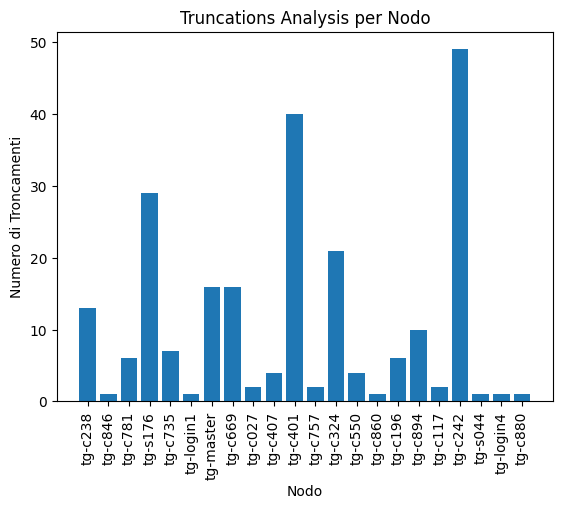

In [19]:
#5)Generazione dei troncamenti
file_path_csv="/content/InfoSistemaMercury.csv"
TruncationsAnalysis(file_path_csv)

Nonostante la scelta di Cwin = 200, che è un buon valore secondo la regola precedentemente citata, potrebbe comunque comportare problemi di troncamento o collisioni. Le tuple sono selezionate in parte in base alla quantità teorica di collisioni e in parte in modo casuale.

Segue una descrizione delle tuple selezionate con analisi degli errori e delle collisioni. Le tuple sono state scelte in parte in base alla quantità di collisioni che presentano e una parte invece randomica.

**tupla 15**:

--------------------------------------------------------------------------
1167669940 tg-c238 DEV +BEGIN HARDWARE ERROR STATE AT CPE

1167669940 tg-c238 DEV +Platform PCI Component Error Info Section

1167669940 tg-c238 MEM Physical Address x, Address Mask: x, Node: x, Card: x, Module: x, Bank: x, Device: x, Row: x, Column: x,

1167669940 tg-c238 MEM Physical Address x, Address Mask: x, Node: x, Card: x, Module: x, Bank: x, Device: x, Row: x, Column: x,

1167669940 tg-master NET setting node state to down

1167669940 tg-c238 DEV +BEGIN HARDWARE ERROR STATE AT CPE

1167669940 tg-c238 DEV +Platform PCI Component Error Info Section

1167669940 tg-c238 MEM Physical Address x, Address Mask: x, Node: x, Card: x, Module: x, Bank: x, Device: x, Row: x, Column: x,

1167669940 tg-c238 MEM Physical Address x, Address Mask: x, Node: x, Card: x, Module: x, Bank: x, Device: x, Row: x, Column: x,

1167669940 tg-master NET setting node state to down

--------------------------------------------------------------------------

In questa tupla sono presenti 3 nodi in collisione che presentano errori diversi. Per un primo pezzo è composta da errori relativi al noto tg-238, al centro da tg-c648, e infine nuovamente da tg-238. Inoltre è presente un singolo errore del nodo tg-master NET

**tupla 26**:

-------------------------------------


1167798435 tg-c781 DEV +BEGIN HARDWARE ERROR STATE AT CPE

1167798435 tg-c781 DEV +Platform PCI Component Error Info Section

1167798435 tg-c781 DEV Component Info: Vendor Id =x x, Device Id =x x, Class Code =x x, Seg Bus Dev Func =x x x x x

1167798587 tg-s176 DEV +BEGIN HARDWARE ERROR STATE AT CPE

1167798587 tg-s176 DEV +END HARDWARE ERROR STATE AT CPE

1167798587 tg-s176 DEV +Platform PCI Component Error Info Section

1167798587 tg-s176 DEV Component Info: Vendor Id =x x, Device Id =x x, Class Code =x x, Seg Bus Dev Func =x x x x x

1167798634 tg-c781 DEV +BEGIN HARDWARE ERROR STATE AT CPE

1167798634 tg-c781 DEV +Platform PCI Component Error Info Section

1167798634 tg-c781 DEV Component Info: Vendor Id =x x, Device Id =x x, Class Code =x x, Seg Bus Dev Func =x x x x x

1167798759 tg-c781 DEV +BEGIN HARDWARE ERROR STATE AT CPE

1167798759 tg-c781 DEV +Platform PCI Component Error Info Section

1167798759 tg-c781 DEV Component Info: Vendor Id =x x, Device Id =x x, Class Code =x x, Seg Bus Dev Func =x x x x x

1167798892 tg-s176 DEV +BEGIN HARDWARE ERROR STATE AT CPE

1167798892 tg-s176 DEV +END HARDWARE ERROR STATE AT CPE

1167798892 tg-s176 DEV +Platform PCI Component Error Info Section

1167798892 tg-s176 DEV +Platform Specific Error Info Section

1167798892 tg-s176 DEV Component Info: Vendor Id =x x, Device Id =x x, Class Code =x x, Seg Bus Dev Func =x x x x x

1167798892 tg-s176 DEV + Platform Specific Error

------------------------------------------

In questa tupla è presente una collisione tra il nodo tg-s176 e tg-c781
Tuttavia il tipo di errore è lo stesso: DEV, ed è quindi possibile che ci sia  una propagazione dell'errore tra questi 2 nodi.

**tupla29**:

--------------------------

1167845528 tg-c238 NET connection down

1167845545 tg-c238 I-O hda: packet command error: error=x

1167845732 tg-c383 DEV GM: LANAI[x]: SRAM PARITY error

1167845732 tg-c383 OTH GM: LANAI[x]: WARNING: libgm gm abort.c:x:gm abort():firmware

-----------------------

In questa tupla la collisione è rappresentata da 2 diversi nodi (tg-c238 e tg-383) che sono scaturiti da errori diversi.


**tupla 114**:

----------------------------------

1168469343 tg-c572 MEM Physical Address x, Address Mask: x, Node: x, Card: x, Module: x, Bank: x, Device: x, Row: x, Column: x,

1168469343 tg-c572 MEM Physical Address x, Address Mask: x, Node: x, Card: x, Module: x, Bank: x, Device: x, Row: x, Column: x,

1168469343 tg-c850 I-O error, dev x:x (hda), sector x

1168469343 tg-c850 I-O error, dev x:x (hda), sector x

1168469343 tg-c850 I-O error, dev x:x (hda), sector x

1168469343 tg-c850 I-O error, dev x:x (hda), sector x

1168469343 tg-c850 I-O error, dev x:x (hda), sector x

1168469344 tg-c572 DEV +BEGIN HARDWARE ERROR STATE AT CPE

1168469344 tg-c572 DEV +Platform PCI Component Error Info Section

1168469344 tg-c572 DEV +Platform Specific Error Info Section

----------------------------------

In questa tupla è presente una collisione poichè il 90% del contenuto è dato dal nodo tg-c572. Il restante 10% è composto da un errore di tipo I-0 di un diverso nodo tg-c850.

**tupla 69**:

--------------

1168094079 tg-login1 I-O x unknown partition table

1168094133 tg-login3 NET connection down

1168094177 tg-login3 I-O hda: packet command error: error=x

1168094269 tg-c669 DEV +BEGIN HARDWARE ERROR STATE AT CPE

1168094269 tg-c669 DEV +Platform PCI Component Error Info Section

1168094269 tg-c669 DEV Component Info: Vendor Id =x x, Device Id =x x, Class Code =x x, Seg Bus Dev Func =x x x x x

1168094364 tg-login3 I-O qlx nvram config link down timeout=x

1168094504 tg-login3 I-O x unknown partition table

1168094504 tg-login3 I-O x unknown partition table

--------------

in questa tupla sono presenti 3 nodi diversi: tg-c669, tg-login1 e tg-login3. Questi ultimi 2 presentano lo stesso errore ed è possibile che l'uno dipenda dall'altro e l'errore si sia propagato. Per quanto riguarda il nodo tg-c669 rappresenta una collisione.

**tupla 298**:

---------

1171321373 tg-c401 DEV +Platform PCI Component Error Info Section

1171321373 tg-c401 DEV Component Info: Vendor Id =x x, Device Id =x x, Class Code =x x, Seg Bus Dev Func =x x x x x

1171321410 tg-c401 DEV +BEGIN HARDWARE ERROR STATE AT CPE

1171321429 tg-c027 PRO +BEGIN HARDWARE ERROR STATE AT CMC

1171321429 tg-c027 PRO +END HARDWARE ERROR STATE AT CMC

1171321429 tg-c027 PRO Device Error Info Section

1171321429 tg-c027 PRO Error Map: x

1171321429 tg-c027 PRO Error Map: x

1171321474 tg-c401 DEV +BEGIN HARDWARE ERROR STATE AT CPE

1171321474 tg-c401 DEV +Platform PCI Component Error Info Section

---------

Rappresenta la tupla con più collisioni in assoluto, in tutto 8. Il contenuto è rappresentato al 99% da errori DEV/MEM legati al nodo tg-c401.
In piccolissima parte c'è la presenta di altri 7 nodi ovvero: tg-c685, tg-c128, tg-master, tg-c735, tg-s176, tg-c027 e tg-c894 rappresentanti tutti una collisione.


Per quanto riguarda invece le ”truncations”, ne analiziamo due in particolare:

**tuple17.txt:** 4 1128951960 346 7928 ’R44-M1-N1’: 4 ’J09-U11’: 4

**tuple18.txt:** 4 1128954084 256 1778 ’R44-M1-N1’: 4 ’J09-U11’: 4

Potremmo affermare che le due tuple rappresentano un fenomeno di truncation;
il problema è che esiste tra le due una distanza temporale di 2500
secondi, che potrebbe far pensare a due errori distinti; in un supercalcolatore,
siccome dei task sono molto ripetitivi questo errore pu`o propagarsi
sulle routine successive; questo potrebbe spiegare la divisione nelle due tuple.

**TTF: distribuzione empirica**

Per stimare l'affidabilità, viene determinata la distribuzione di probabilità (pdf) dei tempi di interarrivo delle tuple (TTF). Successivamente, viene calcolata la funzione di distribuzione cumulativa (CDF) basata sulla pdf empirica.

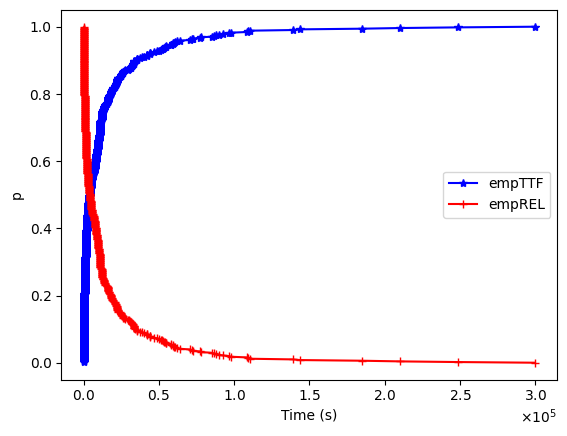

In [20]:
#6)Ploat TTf e Cdf
interarrivals_file = '/content/MercuryLog_interarrivals.txt'
plot_empirical_ttf_reliability(interarrivals_file)

Abbiamo testato 4 diversi fitting per trovare la curva migliore: sono riportati sonno i grafici rispettivamente a Esponenziale (singolo e doppio parametro), Power e Sigmo.


Il fitting che meglio rappresenta l'andamento della curva empirica è eseguito con un modello esponenziale a 2 parametri.

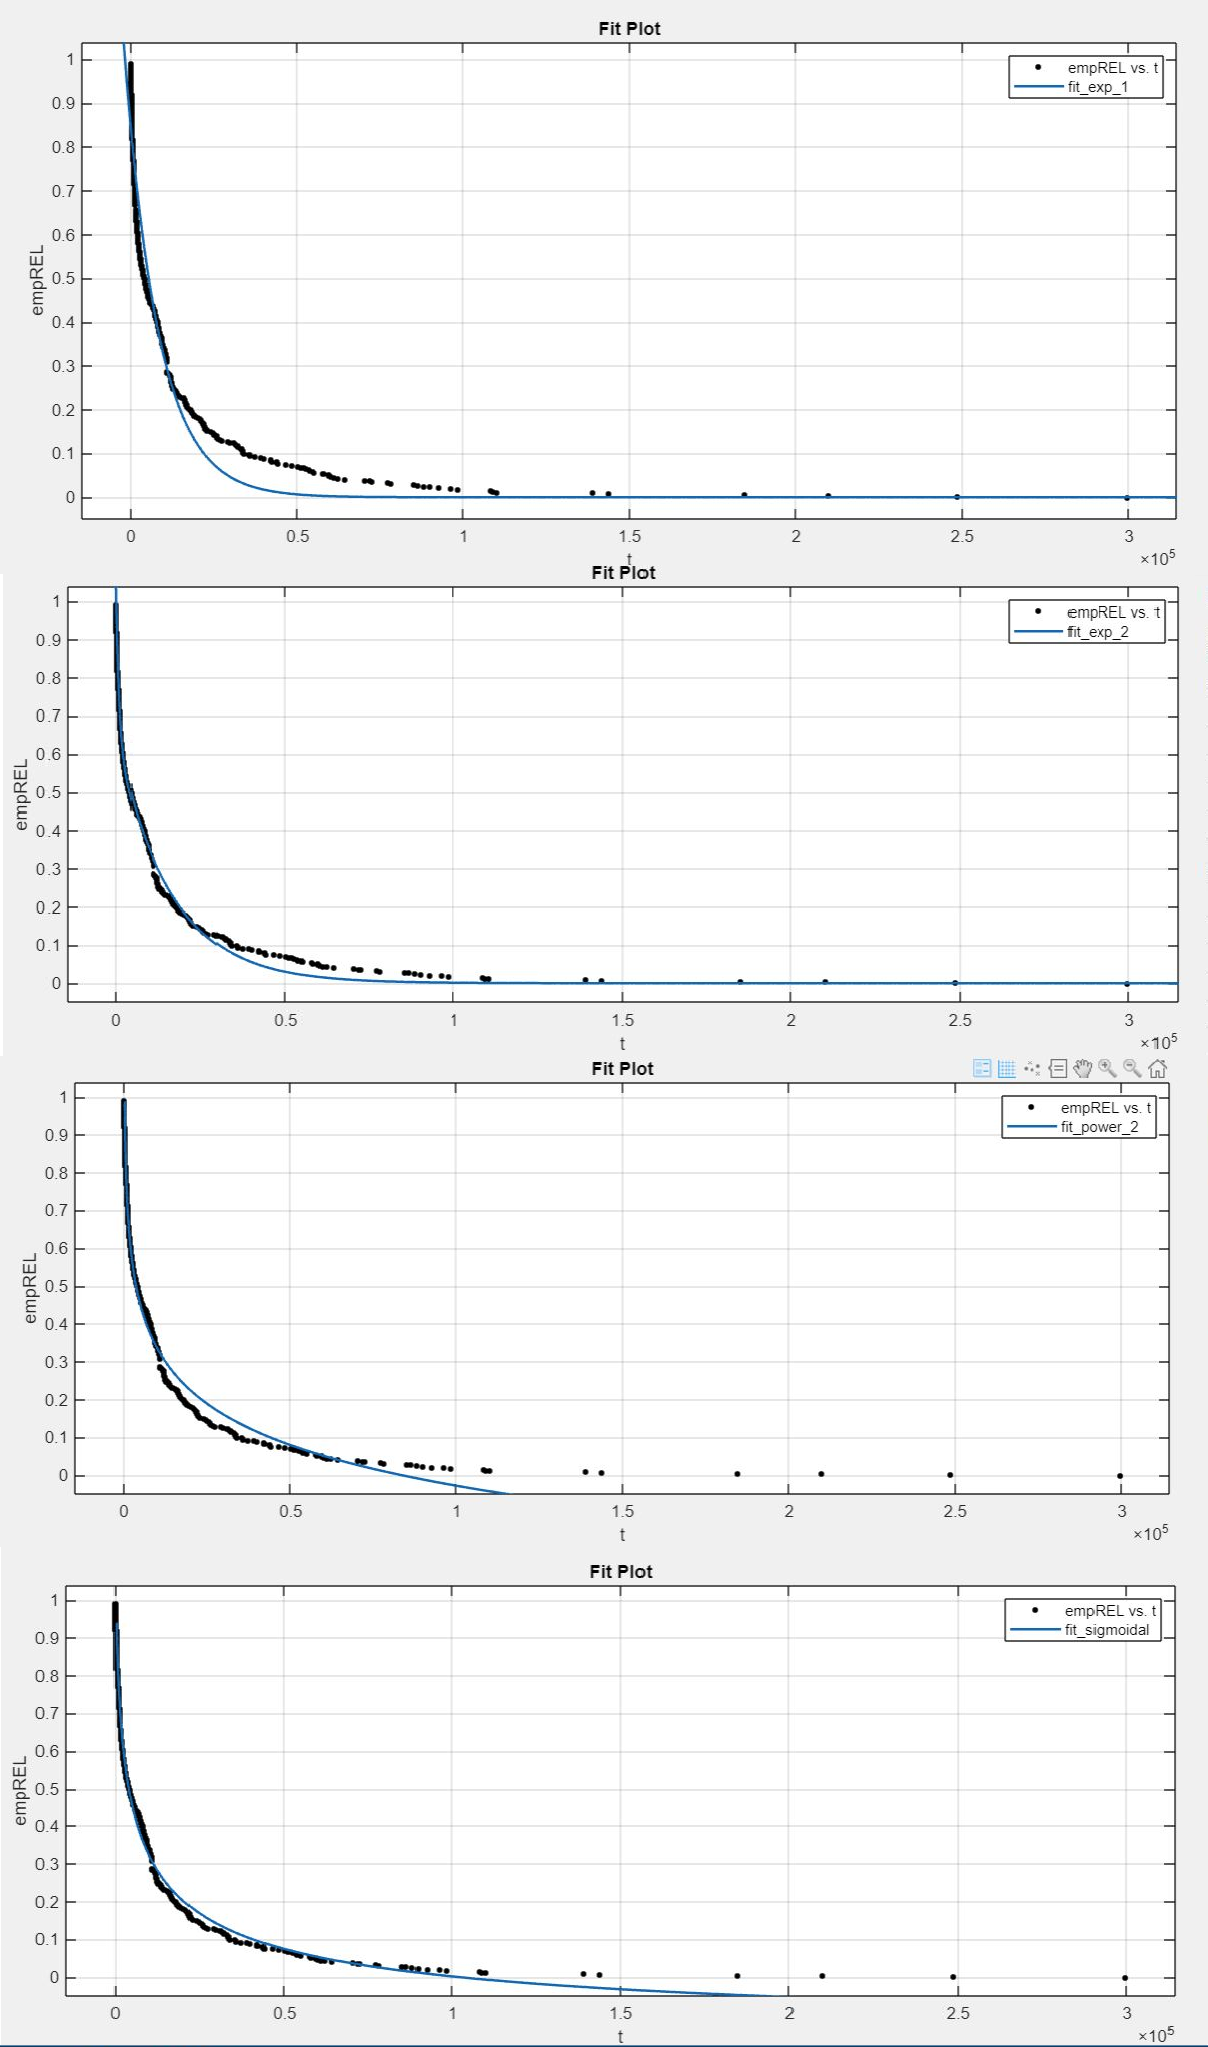


Qui sono riportarti i valori di R-square e SSE:


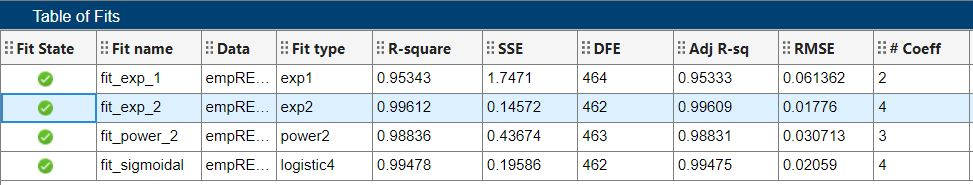

Per validare i risultati utilizziamo il test di Kolmogorov-Smirnov: questo test ci darà come risultato 1 se l’ipotesi nulla è rigettata e quindi il fit non è buono, mentre se è 0 il valore del fitting è buono.

Utilizziamo il seguente codice matlab:

KS exp1
[H1, P1, K1] = kstest2(empREL, fit_exp1(t));

KS exp2
[H2, P2, K2] = kstest2(empREL, fit_exp2(t));


KS power2
[H3, P3, K3] = kstest2(empREL, fit_power2(t));


KS sigmo
[H4, P4, K4] = kstest2(empREL, fit_sigmo(t));




 $$
\begin{array}{|c|c|}
  \hline
  \text{Distribuzione} & \text{H}& \text{P_VALUE} & \text{K} \\
  \hline
  \text{fit_exp1 }& \text{1} & \text{$3.3 \times 10^{-5}$}& \text{0.15} \\
  \hline
    \hline
  \text{fit_exp2}& \text{0} & \text{0.66 }& \text{0.04 } \\
  \hline
    \hline
  \text{fit_power2}& \text{0} & \text{0.45}& \text{0.05 } \\
  \hline
    \hline
  \text{fit_sigmo}& \text{0} & \text{0.55} & \text{0.05 }\\
  \hline
\end{array}
$$

Quello che andiamo a fare ora è andare a vedere se, considerando i vari nodi e
categorie di errore per quanto riguarda Mercury possiamo utilizzare la stessa coalesce window. Qui di seguito è riportato lo script per il calcolo di errori totali, Breakup divisi per nodi e Breakup divisi per categoria.

**Can the same coalesce windows be used across
different nodes and error categories
(Mercury) ?**



```
# Questo è formattato come codice
```

Quello che andiamo a fare in primis è andare ad individuare i nodi e le categorie:

== Total error entries ==
80854
== Breakup by NODE* ==
['tg-c401 -> 62340', 'tg-master -> 4098', 'tg-c572 -> 4030', 'tg-s044 -> 3224', 'tg-c238 -> 1273', 'tg-c242 -> 1067', 'tg-c648 -> 643', 'tg-login3 -> 382', 'tg-c117 -> 268', 'tg-c669 -> 267']
* only the top 10 most occurring nodes are reported


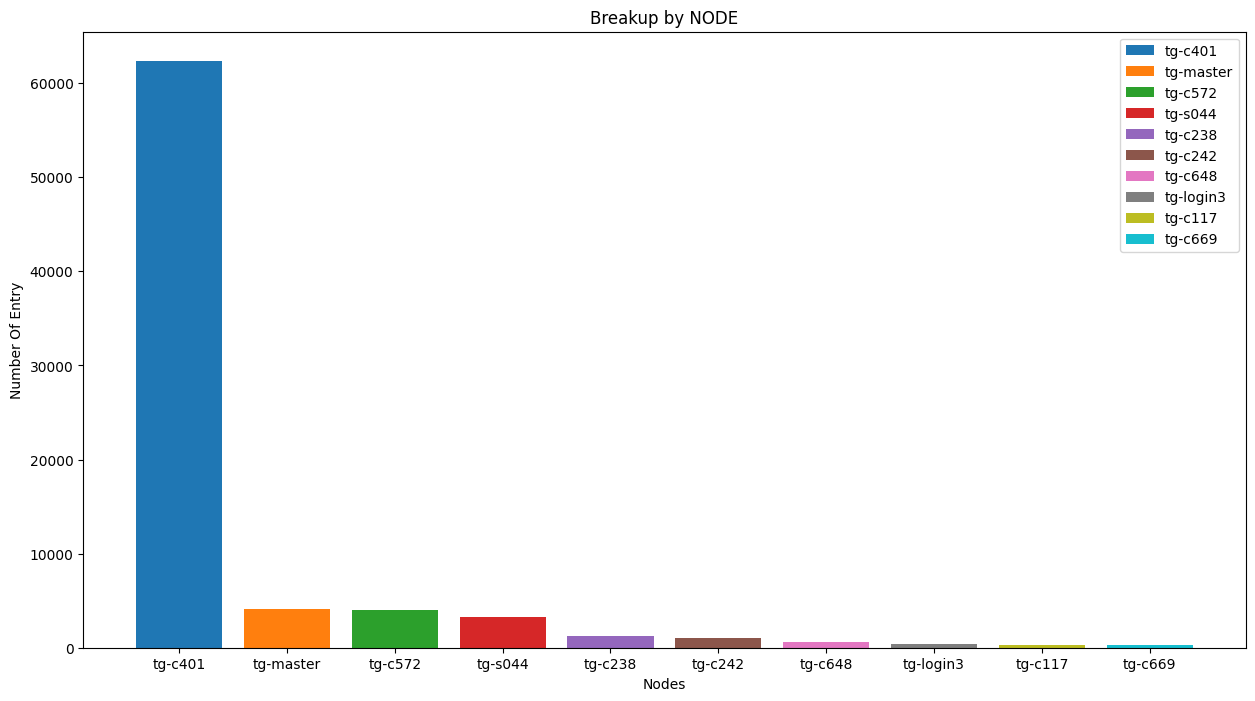

== Breakup by CATEGORY ==
['DEV -> 57248', 'MEM -> 12819', 'I-O -> 5547', 'NET -> 3702', 'PRO -> 1504', 'OTH -> 34']


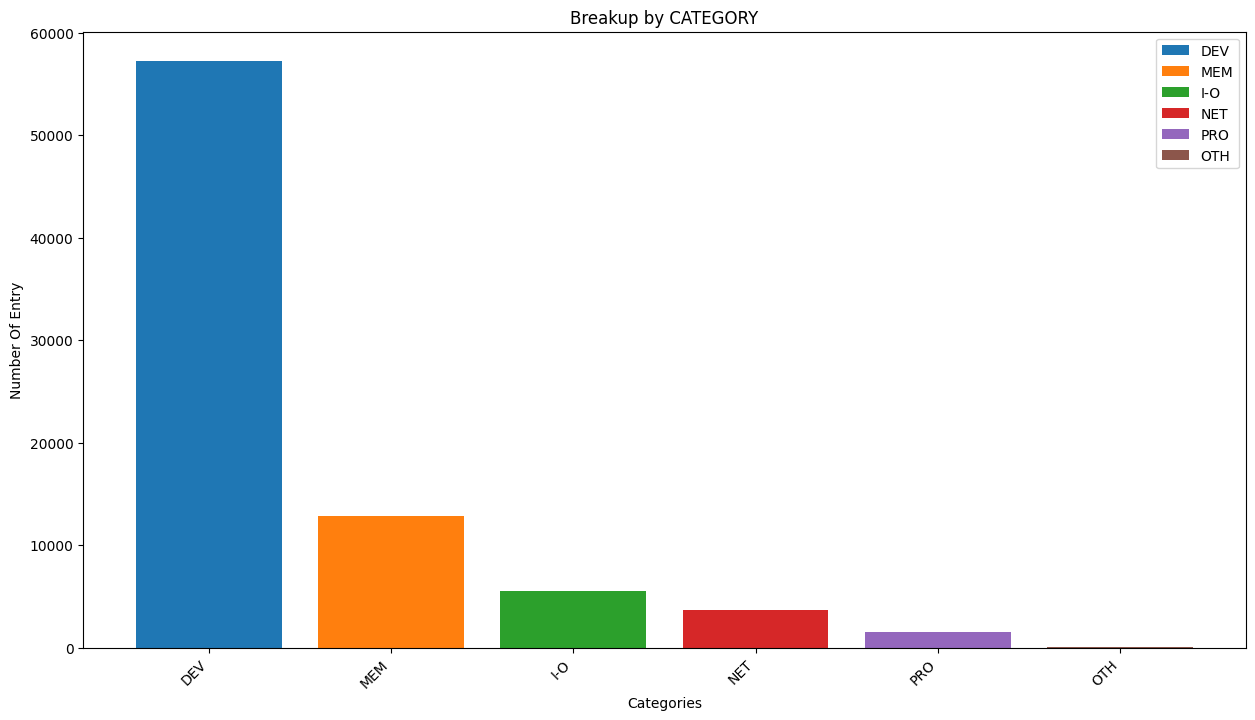

In [21]:
#7)Statistics Info LogFile
statistics_log_file(logfile_Mercury)

In [22]:
#8)Divisione File di log in funzione dei nodi
# Dictionary to map node names to file handles
node_files = {
        'tg-c401': 'tg-c401.txt',
        'tg-master': 'tg-master.txt',
        'tg-c572': 'tg-c572.txt',
        'tg-s044': 'tg-s044.txt',
        'tg-c238': 'tg-c238.txt',
        'tg-c242': 'tg-c242.txt',
        'tg-c648': 'tg-c648.txt',
        'tg-login3': 'tg-login3.txt',
        'tg-c117': 'tg-c117.txt',
        'tg-c669': 'tg-c669.txt',
    }

output_folder = "/content/DivisioneNodiMercury/"
divide_log_by_nodes(logfile_Mercury, output_folder, node_files)

Partendo dai nodi, osservando i grafici riportato qui sotto notiamo come non sia possibile scegliere la stessa coalesce window per i nodi:

c669
s044
c238
c242
c648
c572
c117
login3
c401
master


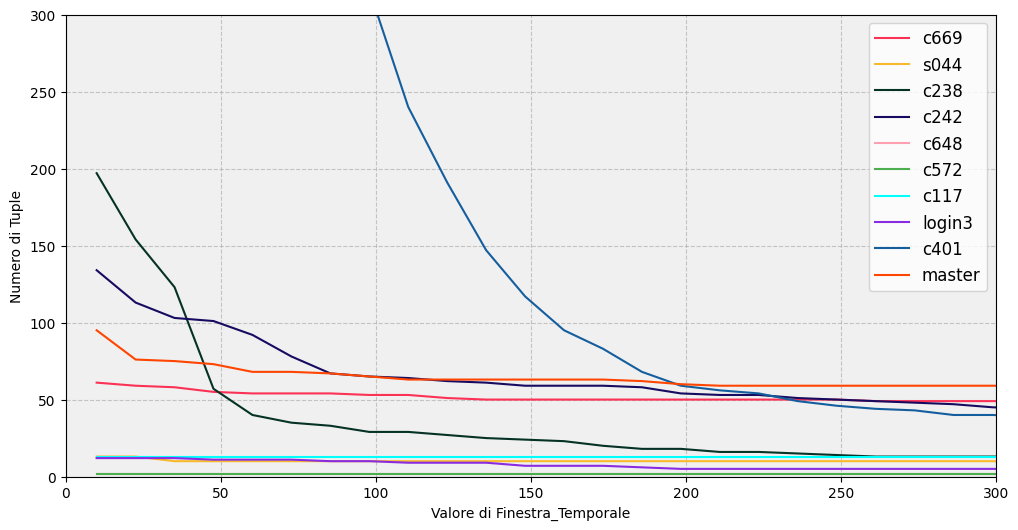

In [23]:
#9) Analisi Sensitiva ai Nodi estratti dal LOg File
#Cartella contenente i file di log
cartella_logs = "/content/DivisioneNodiMercury/"

# Lista per contenere i percorsi dei file di log
logfile_path = []

colors = ['#FC3156', '#f6ba2c', '#053225', '#160B60', '#FF9FB2', '#4cae4f','#00FFFF', '#8A2BE2', '#155E9E', '#FF4500']

# Itera su tutti i file nella cartella
for filename in os.listdir(cartella_logs):
      # Crea il percorso completo del file
      percorso_file = os.path.join(cartella_logs, filename)

      # Verifica se è un file (non una cartella)
      if os.path.isfile(percorso_file):
          # Aggiunge il percorso del file alla lista
          logfile_path.append(percorso_file)

plt.figure(figsize=(12, 6))
test = []
for percorso, c in zip(logfile_path, colors):
    # Estrai il nome del file senza estensione
    nome_file_senza_estensione = os.path.splitext(os.path.basename(percorso))[0]
    # Estrai il testo desiderato
    testo_desiderato = nome_file_senza_estensione.split('-')[-1]
    print(testo_desiderato)
    test.append(testo_desiderato)
    W = np.linspace(10, 500, num=40)  # Genera 100 valori da 0.1 a 5000
    results = sensitivity_analysis(percorso, W)
    plot_sensitivity_analysis_2(W, results,1, color = c)

plt.legend(test, loc='upper right', fontsize=12)
plt.ylim(0,300)  # Imposta l'intervallo dell'asse y
plt.xlim(0,300)
plt.show()

In [24]:
#10) Suddivisione Errori
output_folder = "DivisioneErroriMercury"
split_log_by_error_category(logfile_Mercury, output_folder)

Per le categorie di errore è invece possibile scegliere lo stesso valore di W=190/200 solo per alcune categorie (4 nello specifico), mentre per due non è possibile sceglierle:

MEM_error_log
OTH_error_log
PRO_error_log
NET_error_log
O_error_log
DEV_error_log


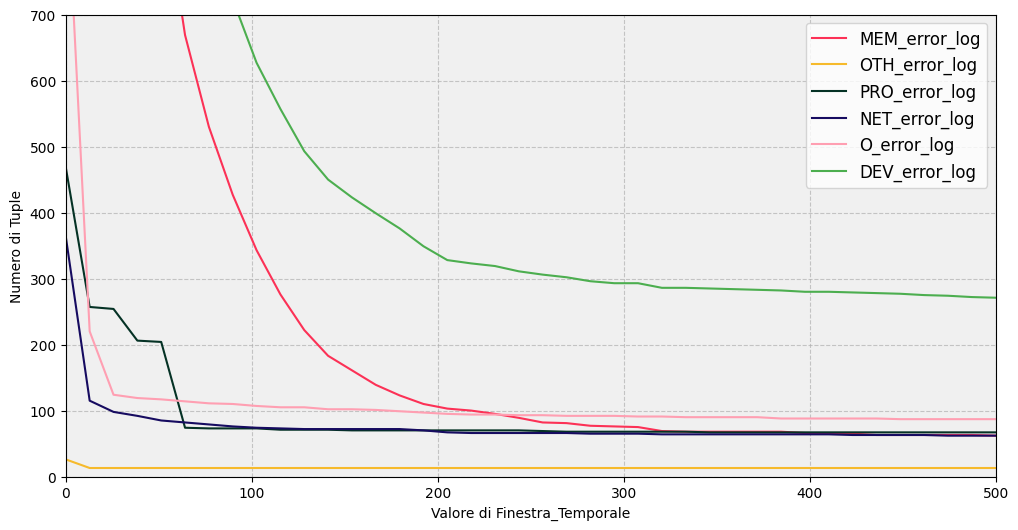

In [25]:
#11)Analisi Sensitività Errori
 # Cartella contenente i file di log
cartella_logs = '/content/DivisioneErroriMercury'

# Lista per contenere i percorsi dei file di log
logfile_path = []

# Itera su tutti i file nella cartella
for filename in os.listdir(cartella_logs):
      # Crea il percorso completo del file
      percorso_file = os.path.join(cartella_logs, filename)

      # Verifica se è un file (non una cartella)
      if os.path.isfile(percorso_file):
          # Aggiunge il percorso del file alla lista
          logfile_path.append(percorso_file)

plt.figure(figsize=(12, 6))
test = []
for percorso, c in zip(logfile_path, colors):
    # Estrai il nome del file senza estensione
    nome_file_senza_estensione = os.path.splitext(os.path.basename(percorso))[0]
    # Estrai il testo desiderato
    testo_desiderato = nome_file_senza_estensione.split('-')[-1]
    print(testo_desiderato)
    test.append(testo_desiderato)
    W = np.linspace(0.1, 500, num=40)  # Genera 100 valori da 0.1 a 5000
    results = sensitivity_analysis(percorso, W)
    plot_sensitivity_analysis_2(W, results,0, color = c)

plt.legend(test, loc='upper right', fontsize=12)
plt.ylim(0,700)  # Imposta l'intervallo dell'asse y
plt.xlim(0,500)
plt.show()

In [26]:
#12) Calcolo intearrivals nodi significativi
logfile_paths = [
    "/content/DivisioneNodiMercury/tg-master.txt",
    "/content/DivisioneNodiMercury/tg-c401.txt",
    "/content/DivisioneNodiMercury/tg-s044.txt",
    "/content/DivisioneNodiMercury/tg-c238.txt"
]
cwinsize_list = [220,200,30, 180]
for path, cwinsize in zip(logfile_paths, cwinsize_list):
        filename = os.path.basename(path)
        text_between = filename.split('/')[-1].replace('.txt', '')
        create_interarrivals_file(path, cwinsize, text_between, "Mercury")

**What about the relationship between the system reliability and nodes reliability? (Mercury)**

Per quanto riguarda la Reliability dei nodi di Mercury, andiamo a considerare in primis i nodi più significativi, cioè quelli con un maggior numero di entries. Ne utilizziamo 3:

1.   tg-master
2.   tg-c401
3.   tg-s044



Andiamo quindi a considerare la reliability dei nodi più quella del sistema generale.

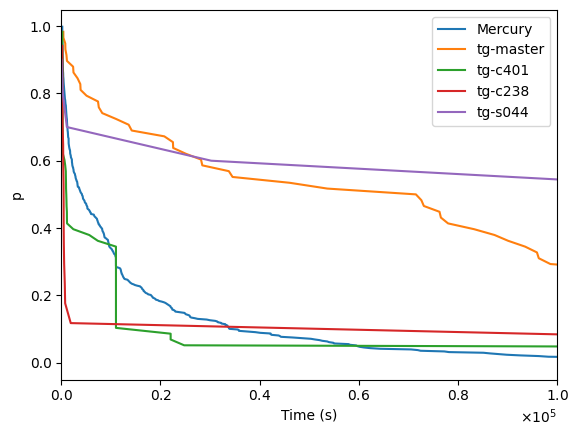

array([0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0. ])

In [27]:
#11)Plottaggio realibility nodi significati e del sistema tot
interarrivals_list = [
    np.loadtxt('/content/MercuryLog_interarrivals.txt'),
    np.loadtxt('/content/MercuryIntarrNode/tg-master_intarr.txt'),
    np.loadtxt('/content/MercuryIntarrNode/tg-c401_intarr.txt'),
    np.loadtxt('/content/MercuryIntarrNode/tg-c238_intarr.txt'),
    np.loadtxt('/content/MercuryIntarrNode/tg-s044_intarr.txt')
]

labels_list = ['Mercury', 'tg-master','tg-c401','tg-c238', 'tg-s044']

plotComp_empirical_ttf_reliability(interarrivals_list, labels=labels_list, xlim=(0, 1e5))

Notiamo come il Nodo con Reliability più alta sia il nodo s044 ed il nodo Master. La reliability del sistema è molto inferiore ed è simile al nodo tg-c401

#2.Analisi BlueGene

**Scelta della coalescence window e creazione delle
tuple**

Per BlueGene seguiamo gli stessi passaggi effettuati per Mercury:

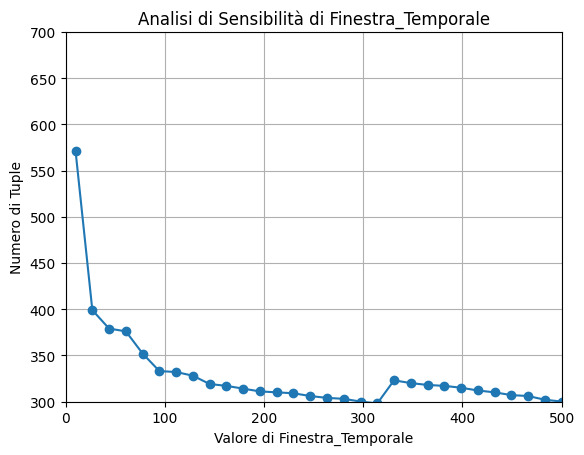

In [ ]:
#1)AnalisiSensitività BlueGene
W = np.linspace(10, 500, num=30)  # Genera 100 valori da 0.1 a 5000
results = sensitivity_analysis(logfile_BlueGene, W)
plot_sensitivity_analysis(W, results,1)

In [ ]:
#2) Stima tuple
cwin, tcount = estimate_tuple_count(logfile_BlueGene,220)
print(f"Con un Cwin={cwin} posso generare {tcount} tuple")

Con un Cwin=220 posso generare 340 tuple


In [ ]:
#3)Generazione Tuple
process_log_file(logfile_BlueGene,cwin,"BlgLog")

#3.1)#Ragruppamento delle info di ogni singola tupla all'interno del file csv InfoSistemaBlg.csv

input_file = '/content/BlgLog_220tupling'  # Sostituisci con il percorso effettivo del tuo file di input
output_file = '/content/InfoSistemaBlg.csv'
counter=1
prefisso = "tuple"
estensione = ".txt"
# Ottengo la lista dei file nella cartella
onlyfiles = [f"{prefisso}{i}{estensione}" for i in range(1,tcount)]
# Per ogni tupla
for namefile in onlyfiles:
            # Leggo la tupla
            dir=input_file+"/"+namefile
            create_csv(dir, output_file,counter)
            counter=counter+1

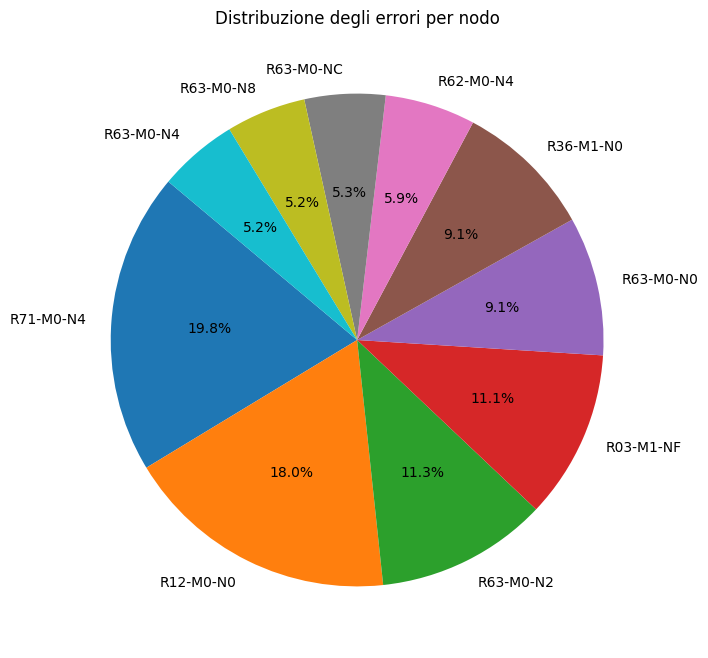

In [ ]:
# Dati
error_entries = 125624
node_breakup = [('R71-M0-N4', 1716), ('R12-M0-N0', 1563), ('R63-M0-N2', 976),
                ('R03-M1-NF', 960), ('R63-M0-N0', 791), ('R36-M1-N0', 788),
                ('R62-M0-N4', 515), ('R63-M0-NC', 460), ('R63-M0-N8', 454),
                ('R63-M0-N4', 452)]

# Estrai i valori e le etichette per il grafico a torta
labels = [entry[0] for entry in node_breakup]
sizes = [entry[1] for entry in node_breakup]

# Crea il grafico a torta
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribuzione degli errori per nodo')
plt.show()

**Analisi delle truncations e delle collisioni**

Troncamento: tupla 17 - tupla 18 --- Nodo: R44-M1-N1
Troncamento: tupla 28 - tupla 29 --- Nodo: R00-M0-NC
Troncamento: tupla 31 - tupla 32 --- Nodo: R51-M0-N8
Troncamento: tupla 36 - tupla 37 --- Nodo: R36-M1-N5
Troncamento: tupla 37 - tupla 38 --- Nodo: R36-M1-N5
Troncamento: tupla 38 - tupla 39 --- Nodo: R36-M1-N5
Troncamento: tupla 39 - tupla 40 --- Nodo: R36-M1-N5
Troncamento: tupla 40 - tupla 41 --- Nodo: R36-M1-N5
Troncamento: tupla 41 - tupla 42 --- Nodo: R36-M1-N5
Troncamento: tupla 46 - tupla 47 --- Nodo: R02-M0-N4
Troncamento: tupla 47 - tupla 48 --- Nodo: R02-M0-N4
Troncamento: tupla 48 - tupla 49 --- Nodo: R02-M0-N4
Troncamento: tupla 54 - tupla 55 --- Nodo: R53-M1-NC
Troncamento: tupla 92 - tupla 93 --- Nodo: R42-M1-N3
Troncamento: tupla 170 - tupla 171 --- Nodo: R57-M1-N0
Troncamento: tupla 194 - tupla 195 --- Nodo: R36-M1-N0
Troncamento: tupla 301 - tupla 302 --- Nodo: R21-M1-N7
Troncamento: tupla 317 - tupla 318 --- Nodo: R12-M0-N0
Troncamento: tupla 318 - tupla 319 ---

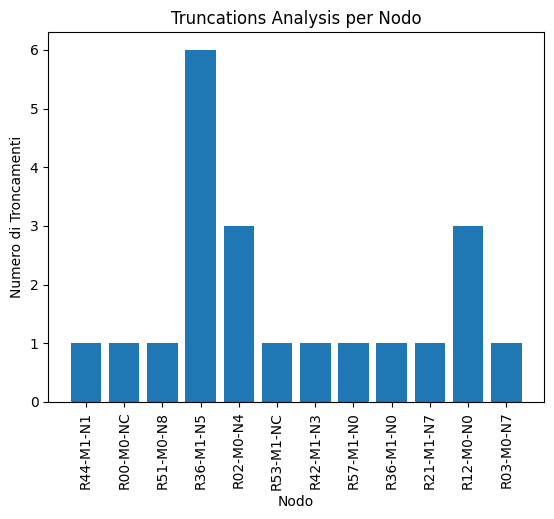

In [ ]:
#5) Generazione troncamenti
# Esempio di utilizzo
csv_path = "/content/InfoSistemaBlg.csv"
TruncationsAnalysis(csv_path)


Analisi tupla n. 15:

---------------------------

1128943059 R44-M1-N8 J18-U11  Microloader Assertion

1128943059 R44-M1-N8 J18-U01  Microloader Assertion

1128943059 R44-M1-NC J18-U11  Microloader Assertion

1128943059 R44-M1-NC J18-U01  Microloader Assertion

1128943059 R44-M1-N4 J18-U11  Microloader Assertion

1128943060 R24-M0-N0 J18-U01  Microloader Assertion

1128943060 R24-M0-NC J18-U11  Microloader Assertion

1128943060 R24-M0-NC J18-U01  Microloader Assertion

1128943061 R44-M1-N8 J18-U11  CHECK_INITIAL_GLOBAL_INTERRUPT_VALUES

1128943061 R44-M1-N8 J18-U01  CHECK_INITIAL_GLOBAL_INTERRUPT_VALUES

1128943061 R44-M1-NC J18-U11  CHECK_INITIAL_GLOBAL_INTERRUPT_VALUES

1128943061 R44-M1-NC J18-U01  CHECK_INITIAL_GLOBAL_INTERRUPT_VALUES

1128943062 R24-M0-N0 J18-U11  CHECK_INITIAL_GLOBAL_INTERRUPT_VALUES

1128943062 R24-M0-N0 J18-U01  CHECK_INITIAL_GLOBAL_INTERRUPT_VALUES

1128943063 R24-M0-NC J18-U11  CHECK_INITIAL_GLOBAL_INTERRUPT_VALUES

1128943063 R24-M0-NC J18-U01  CHECK_INITIAL_GLOBAL_INTERRUPT_VALUES

---------------------------------

Notiamo come non si riesce a trovare una relazione tra i nodi; la troppa varietà e quindi la presunta incorrelazione tra i nodi ci porta ad affermare che questa sia effettivamente una collisione.

Per quanto riguarda invece le ”truncations”, ne analiziamo due in particolare:

**tuple17.txt** 4 1128951960 346 7928 ’R44-M1-N1’: 4 ’J09-U11’: 4

**tuple18.txt** 4 1128954084 256 1778 ’R44-M1-N1’: 4 ’J09-U11’: 4


Potremmo affermare che le due tuple rappresentano un fenomeno di truncation;
il problema è che esiste tra le due una distanza temporale di 2500
secondi, che potrebbe far pensare a due errori distinti; in un supercalcolatore,
siccome dei task sono molto ripetitivi questo errore può propagarsi
sulle routine successive; questo potrebbe spiegare la divisione nelle due tuple.

**TTF: distribuzione empirica**

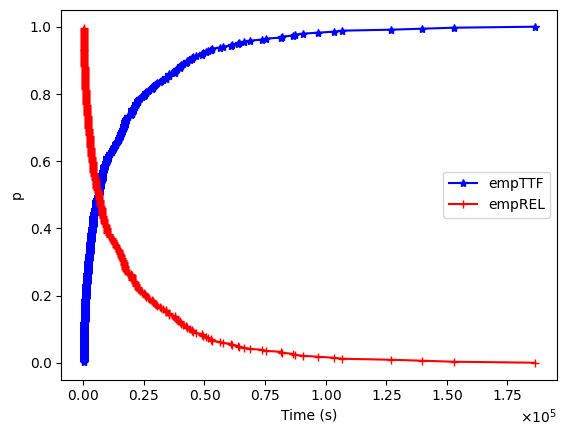

In [ ]:
#6)Ploat TTf e Cdf
interarrivals_file = '/content/BlgLog_interarrivals.txt'
plot_empirical_ttf_reliability(interarrivals_file)

In questo caso abbiamo testato 5 diversi fitting per trovare la curva migliore: Esponenziale (singolo e doppio parametro), Power, Sigmo e Rational.


Il fitting che meglio rappresenta l'andamento della curva empirica è eseguito con un modello Sigmo.

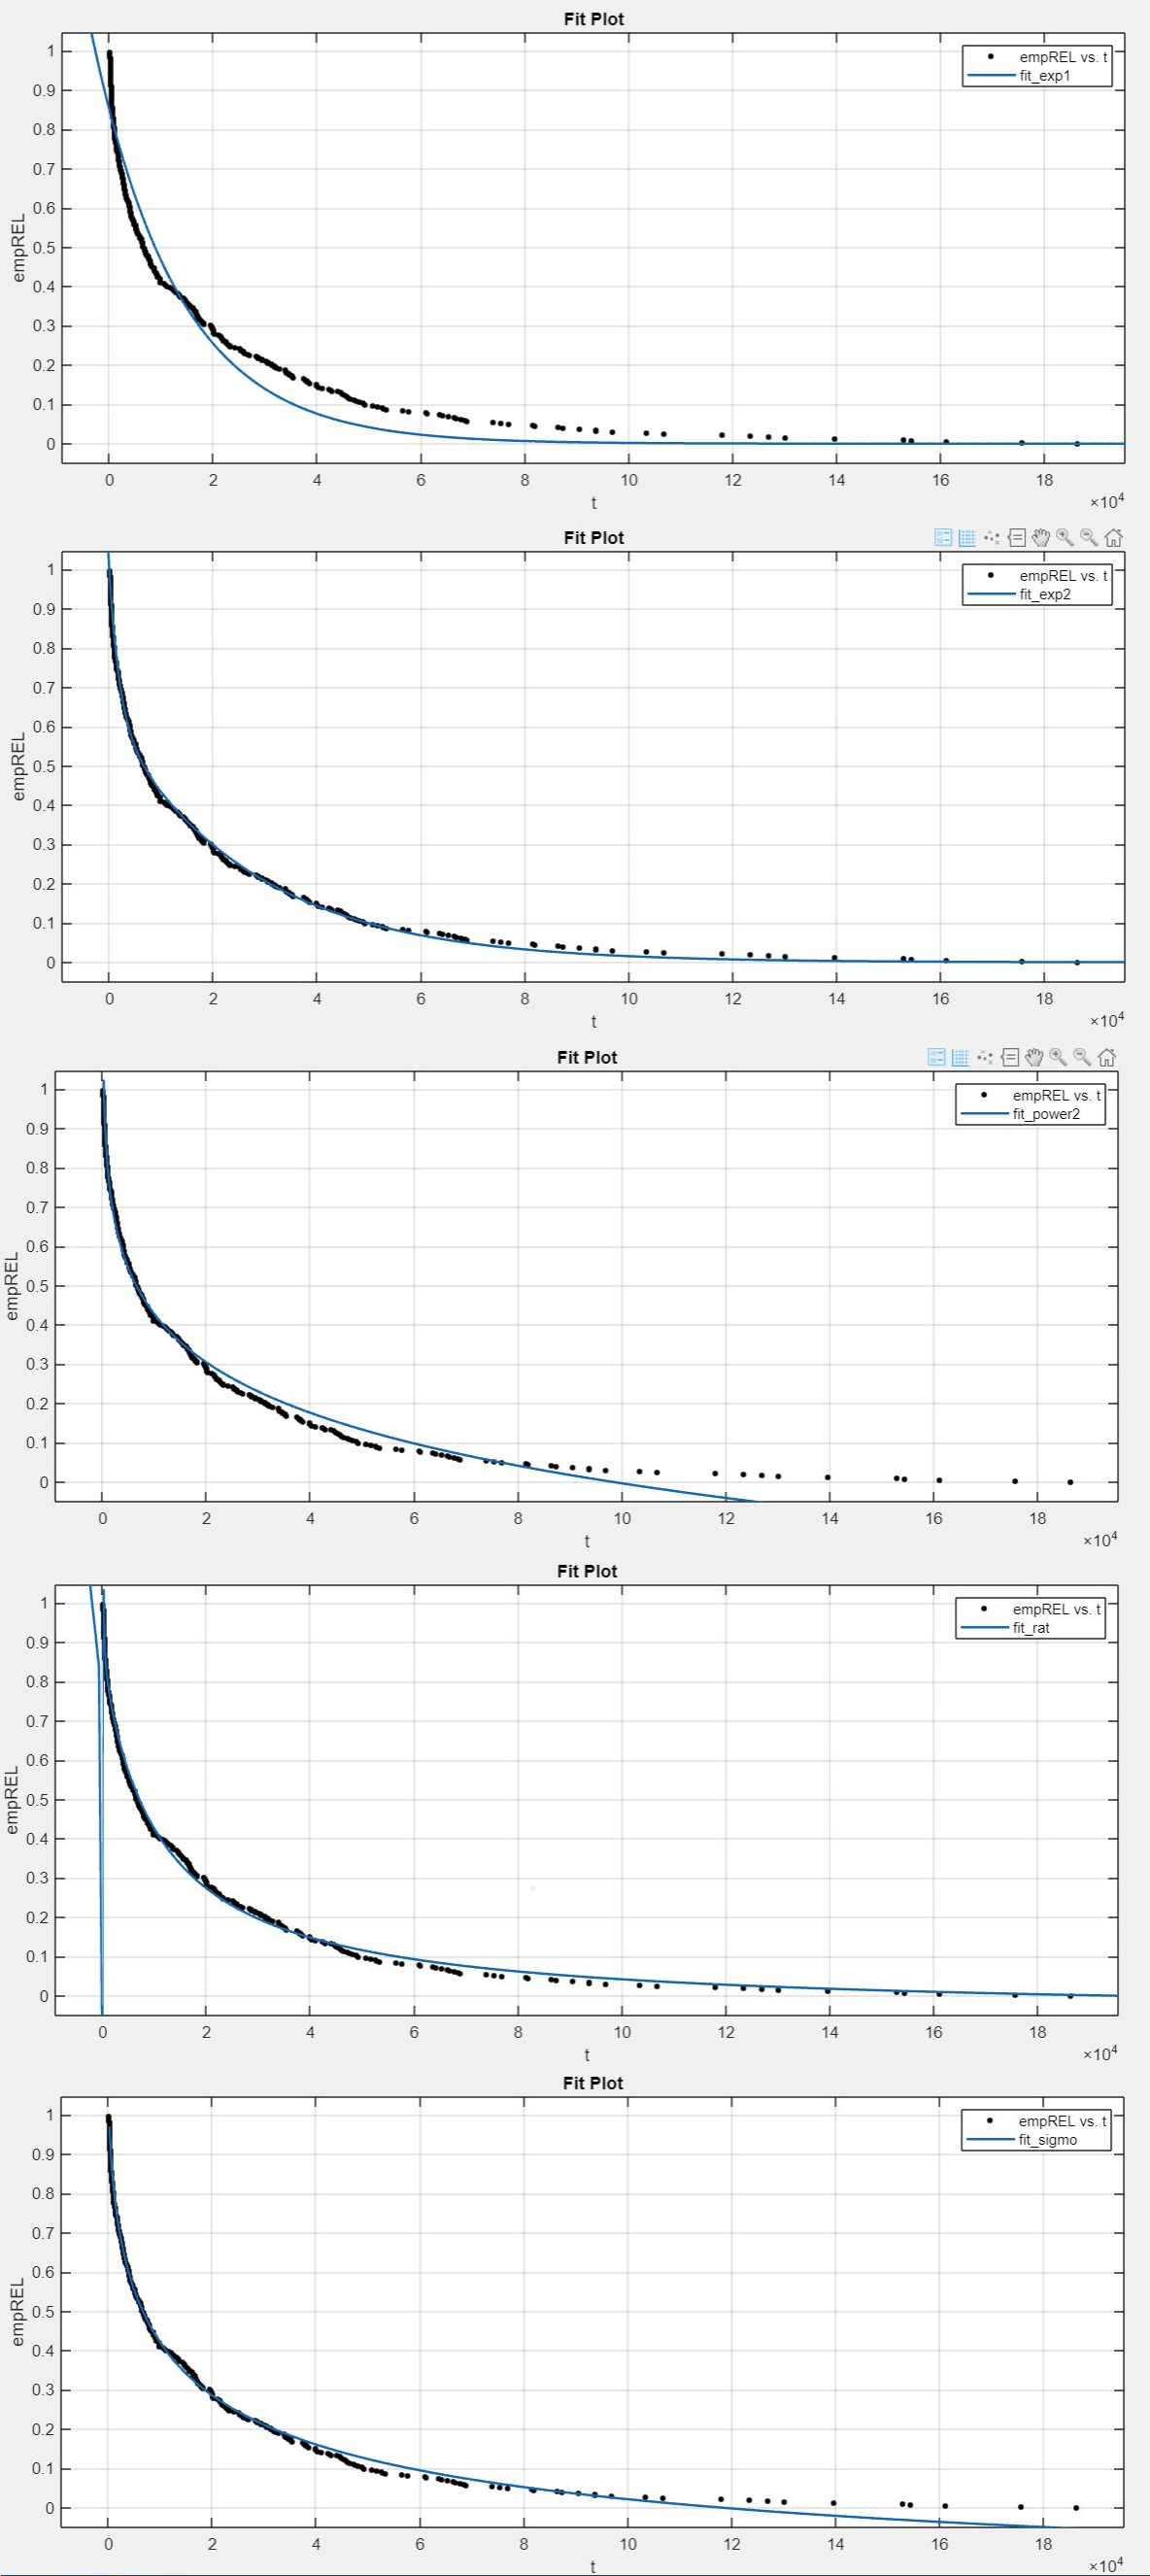

Valori di R-square e SSE:

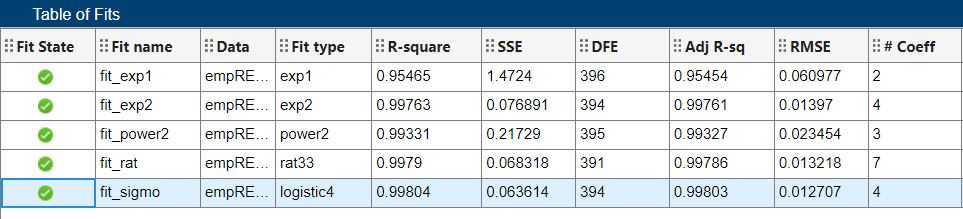

Per validare i risultati utilizziamo il test di Kolmogorov-Smirnov: questo test ci darà come risultato 1 se l’ipotesi nulla è rigettata e quindi il fit non è buono, mentre se è 0 il valore del fitting è buono. Possiamo notare che la fit_sigmo e la fit_rational hanno lo stesso P_VALUE e stessa K.

Utilizziamo il seguente codice matlab:

KS exp1
[H1, P1, K1] = kstest2(empREL, fit_exp1(t));

KS exp2
[H2, P2, K2] = kstest2(empREL, fit_exp2(t));


KS power2
[H3, P3, K3] = kstest2(empREL, fit_power2(t));


KS sigmo
[H4, P4, K4] = kstest2(empREL, fit_sigmo(t));

KS rational
[H5, P5, K5] = kstest2(empREL, fit_rat(t));

 $$
\begin{array}{|c|c|}
  \hline
  \text{Distribuzione} & \text{H}& \text{P_VALUE} & \text{K} \\
  \hline
  \text{fit_exp1 }& \text{1} & \text{$2.7 \times 10^{-4}$}& \text{0.14} \\
  \hline
    \hline
  \text{fit_exp2}& \text{0} & \text{0.80}& \text{0.0452} \\
  \hline
    \hline
  \text{fit_power2}& \text{0} & \text{0.89}& \text{0.0402 } \\
  \hline
    \hline
  \text{fit_sigmo}& \text{0} & \text{0.9928} & \text{0.0302 }\\
  \hline
      \hline
  \text{fit_rational}& \text{0} & \text{0.9928} & \text{0.0302 }\\
  \hline
\end{array}
$$

**Can the same coalesce windows be used across
different nodes
(BlueGene) ?**

Come abbiamo fatto precedentemente individuiamo i nodi e le categorie:

== Total error entries ==
125624
== Breakup by NODE* ==
['R71-M0-N4 -> 1716', 'R12-M0-N0 -> 1563', 'R63-M0-N2 -> 976', 'R03-M1-NF -> 960', 'R63-M0-N0 -> 791', 'R36-M1-N0 -> 788', 'R62-M0-N4 -> 515', 'R63-M0-NC -> 460', 'R63-M0-N8 -> 454', 'R63-M0-N4 -> 452']
* only the top 10 most occurring nodes are reported


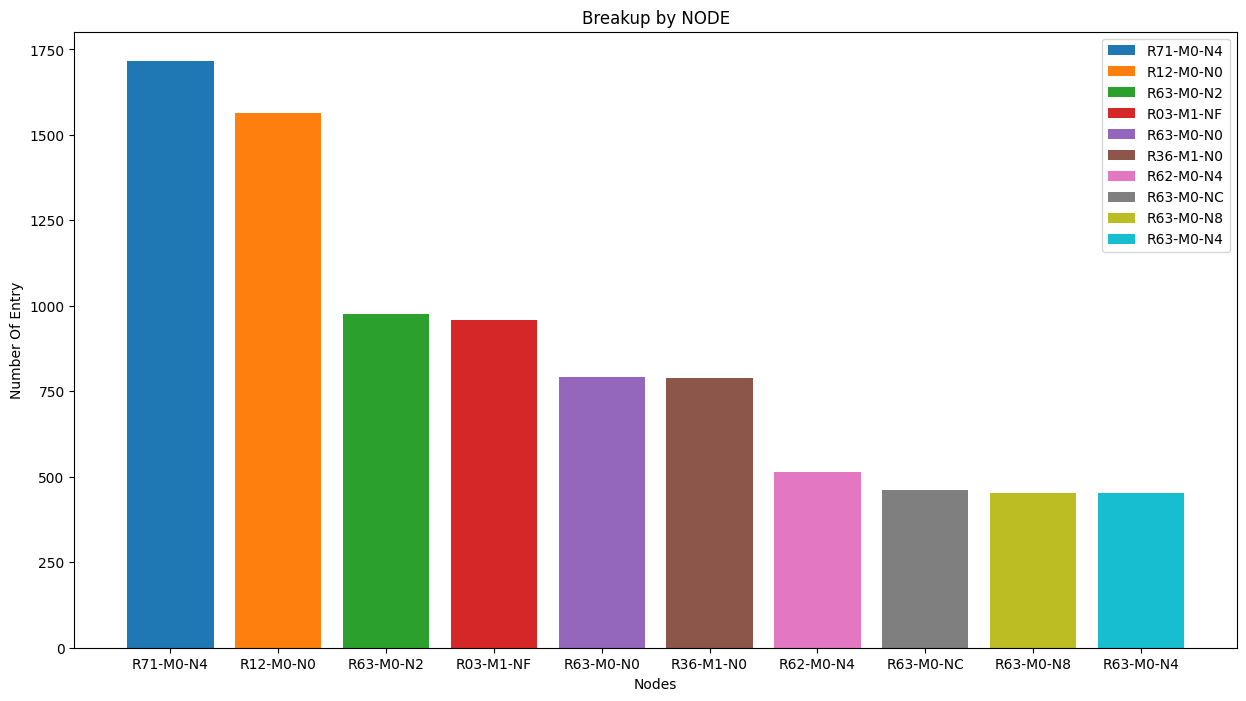

== Breakup by CATEGORY ==
['J18-U11 -> 50055', 'J18-U01 -> 49932', 'J14-U01 -> 2257', 'J12-U01 -> 1877', 'J07-U01 -> 1780', 'J10-U11 -> 1333', 'J03-U11 -> 1020', 'J16-U11 -> 973', 'J06-U11 -> 960', 'J11-U11 -> 888']


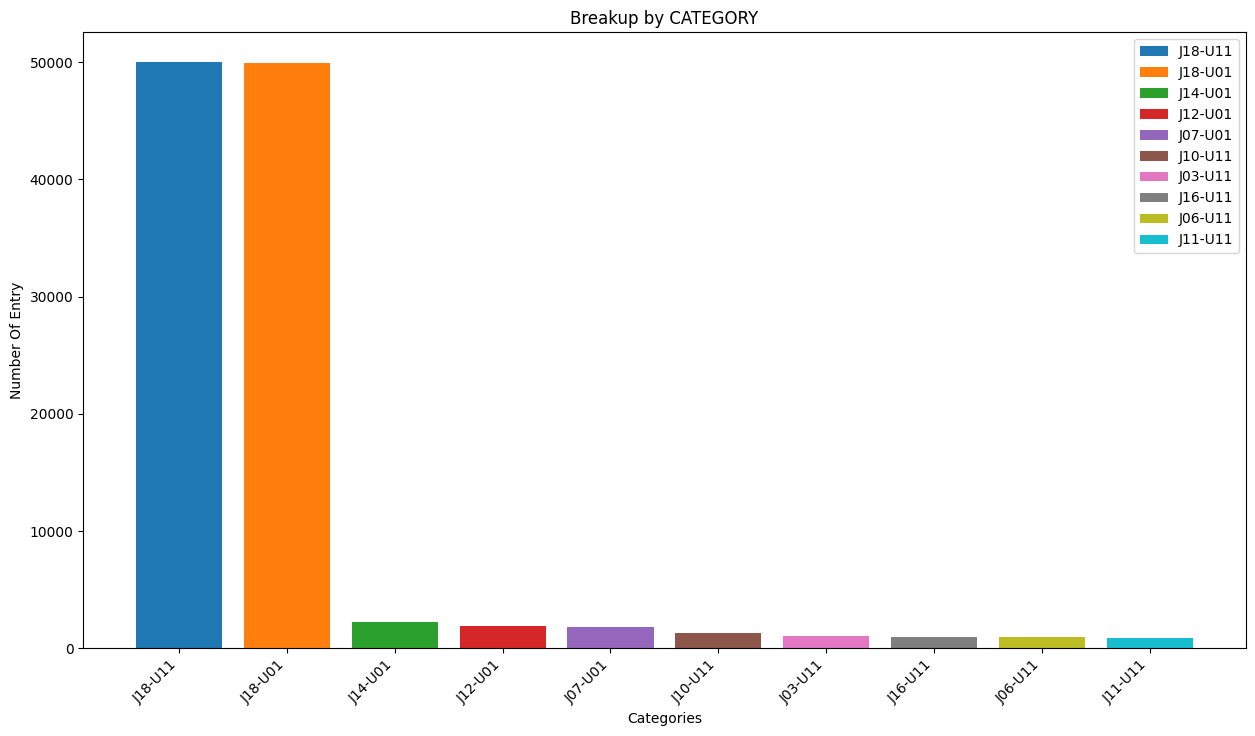

In [ ]:
#7)Statistics Info LogFile
statistics_log_file(logfile_BlueGene)

In [ ]:
#8)Divisione File di log in funzione dei nodi
# Dictionary to map node names to file handles
node_files = {
    'R71-M0-N4': 'R71-M0-N4.txt',
    'R12-M0-N0': 'R12-M0-N0.txt',
    'R63-M0-N2': 'R63-M0-N2.txt',
    'R03-M1-NF': 'R03-M1-NF.txt',
    'R63-M0-N0': 'R63-M0-N0.txt',
    'R36-M1-N0': 'R36-M1-N0.txt',
    'R62-M0-N4': 'R62-M0-N4.txt',
    'R63-M0-NC': 'R63-M0-NC.txt',
    'R63-M0-N8': 'R63-M0-N8.txt',
    'R63-M0-N4': 'R63-M0-N4.txt',
}

output_folder = "/content/DivisioneNodiBlg/"
divide_log_by_nodes(logfile_BlueGene, output_folder, node_files)

\
*   Voce elenco
*   Voce elenco

tutti i nodi.

R63-M0-NC
R63-M0-N2
R63-M0-N0
R36-M1-N0
R12-M0-N0
R71-M0-N4
R63-M0-N8
R03-M1-NF
R63-M0-N4
R62-M0-N4


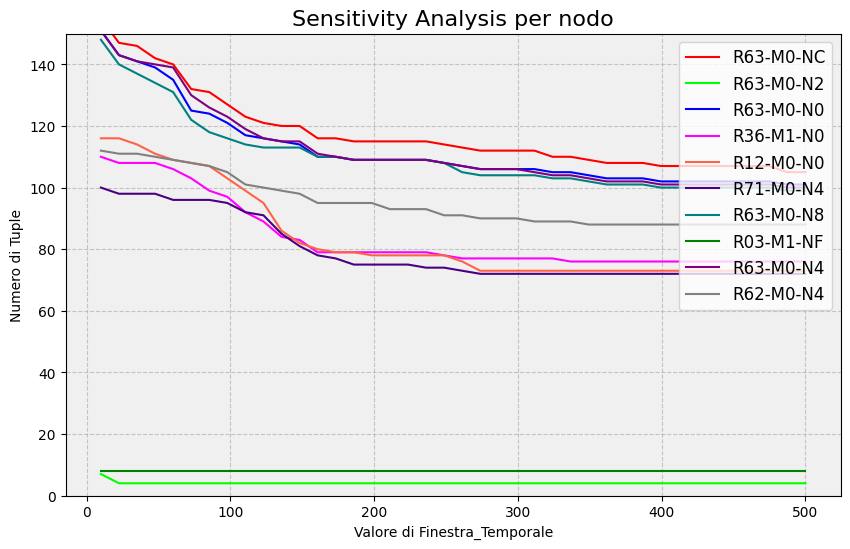

In [ ]:
#9) Analisi Sensitiva ai Nodi estratti dal LOg File
#Cartella contenente i file di log
cartella_logs = "/content/DivisioneNodiBlg/"

# Lista per contenere i percorsi dei file di log
logfile_path = []

# Itera su tutti i file nella cartella
for filename in os.listdir(cartella_logs):
      # Crea il percorso completo del file
      percorso_file = os.path.join(cartella_logs, filename)

      # Verifica se è un file (non una cartella)
      if os.path.isfile(percorso_file):
          # Aggiunge il percorso del file alla lista
          logfile_path.append(percorso_file)

colors = ['#FF0000', '#00FF00', '#0000FF', '#FF00FF', '#FF6347', '#4B0082', '#008080', '#008000', '#800080', '#808080']

plt.figure(figsize=(10, 6))
test = []
plt.title('Sensitivity Analysis per nodo', fontsize=16)
for percorso, c in zip(logfile_path, colors):
    # Estrai il nome del file senza estensione
    nome_file_senza_estensione = os.path.splitext(os.path.basename(percorso))[0]
    # Estrai il testo desiderato
    testo_desiderato = nome_file_senza_estensione
    print(testo_desiderato)
    test.append(testo_desiderato)
    W = np.linspace(10, 500, num=40)  # Genera 100 valori da 0.1 a 5000
    results = sensitivity_analysis(percorso, W)
    plot_sensitivity_analysis_2(W, results,1, color = c)


plt.ylim(0,150)  # Imposta l'intervallo dell'asse y
plt.legend(test, loc='upper right', fontsize=12)
plt.show()

In [ ]:
#10) Calcolo intearrivals nodi significativi
logfile_paths = [
    "/content/DivisioneNodiBlg/R71-M0-N4.txt",
    "/content/DivisioneNodiBlg/R12-M0-N0.txt",
    "/content/DivisioneNodiBlg/R63-M0-N2.txt",
    "/content/DivisioneNodiBlg/R03-M1-NF.txt",
    "/content/DivisioneNodiBlg/R63-M0-N0.txt",
]

cwinsize_list = [290,300,10, 10, 420]

for path, cwinsize in zip(logfile_paths, cwinsize_list):
        filename = os.path.basename(path)
        text_between = filename.split('/')[-1].replace('.txt', '')
        create_interarrivals_file(path, cwinsize, text_between, "Blg")

**What about the relationship between the system reliability and nodes reliability? (BlueGene)**

Per quanto riguarda la Reliability dei nodi di BlueGene, andiamo a considerare nuovamente i nodi più significativi. Ne utilizziamo 3:


1.   R03-M1-NF
2.   R12-M0-N0
3.   R71-M0-N4


Andiamo quindi a considerare la reliability dei nodi più quella del sistema generale.

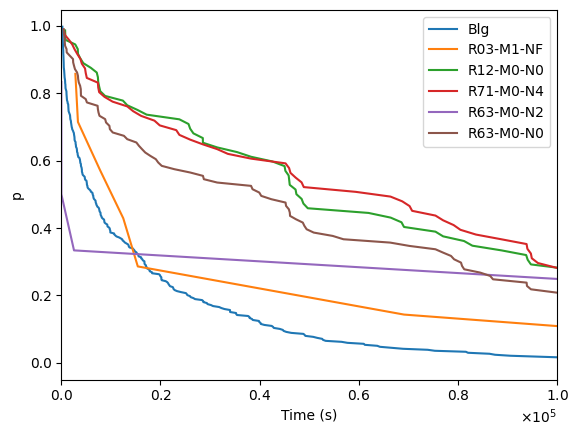

In [ ]:
#12)Plottaggio realibility nodi significati e del sistema tot
interarrivals_list = [
    np.loadtxt('/content/BlgLog_interarrivals.txt'),
    np.loadtxt('/content/BlgIntarrNode/R03-M1-NF_intarr.txt'),
    np.loadtxt('/content/BlgIntarrNode/R12-M0-N0_intarr.txt'),
    np.loadtxt('/content/BlgIntarrNode/R71-M0-N4_intarr.txt'),
    np.loadtxt('/content/BlgIntarrNode/R63-M0-N2_intarr.txt'),
    np.loadtxt('/content/BlgIntarrNode/R63-M0-N0_intarr.txt')
]

labels_list = ['Blg', 'R03-M1-NF','R12-M0-N0','R71-M0-N4', 'R63-M0-N2', 'R63-M0-N0']

plotComp_empirical_ttf_reliability(interarrivals_list, labels=labels_list, xlim=(0, 1e5))

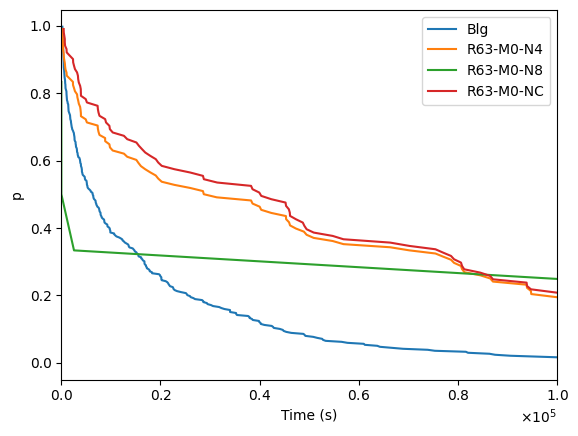

In [ ]:
logfile_paths = [
    "/content/DivisioneNodiBlg/R63-M0-N2.txt",
    "/content/DivisioneNodiBlg/R63-M0-N0.txt",
    "/content/DivisioneNodiBlg/R63-M0-NC.txt",
    "/content/DivisioneNodiBlg/R63-M0-N8.txt",
    "/content/DivisioneNodiBlg/R63-M0-N4.txt",
]

cwinsize_list = [10,420,220, 220, 200]

for path, cwinsize in zip(logfile_paths, cwinsize_list):
        filename = os.path.basename(path)
        text_between = filename.split('/')[-1].replace('.txt', '')
        create_interarrivals_file(path, cwinsize, text_between, "Blg")

interarrivals_list = [
    np.loadtxt('/content/BlgLog_interarrivals.txt'),
    np.loadtxt('/content/BlgIntarrNode/R63-M0-N4_intarr.txt'),
    np.loadtxt('/content/BlgIntarrNode/R63-M0-N2_intarr.txt'),
    np.loadtxt('/content/BlgIntarrNode/R63-M0-N0_intarr.txt')
]

labels_list = ['Blg', 'R63-M0-N4','R63-M0-N8','R63-M0-NC', 'R63-M0-N2', 'R63-M0-N0']

plotComp_empirical_ttf_reliability(interarrivals_list, labels=labels_list, xlim=(0, 1e5))

Anche in questo caso la reliability del sistema è la più bassa rispetto ai nodi analizzati. La reliability più alta è espressa dai nodi R12-M0-N0 e R71-MO-N4

In [ ]:
def cdfcalc(data):
        sorted_data = np.sort(data)
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        return cdf, sorted_data

interarrivals = np.loadtxt('/content/BlgIntarrNode/R63-M0-N4_intarr.txt')
y_CDF, ttf = cdfcalc(interarrivals)
emp_TTF = y_CDF[:len(ttf)]  # Ensure emp_TTF and ttf have the same length
emp_REL = 1 - emp_TTF

#3.Confronto tra Mercury e BlueGene

Di seguito è riportato il confronto tra la Reliability di Mercury e BlueGene. Facendo l’integrale della curva ottenuta tramite l’operazione di fitting utilizzando la funzione iperesponenziale.

Otteniamo che per quanto riguarda BlueGene, l’ **$ MTTF_{BLG} = 17653s $,** ovvero 4,9 ore, mentre riguardo Mercury abbiamo che **$ MTTF_{Mercury} = 10741s $**, ovvero 2,9 ore.

Da questo contronto otteniamo che BlueGene è più reliable rispetto a mercury.
Anche il grafico seguente mostra come la reliablity di BlueGene sia
migliore

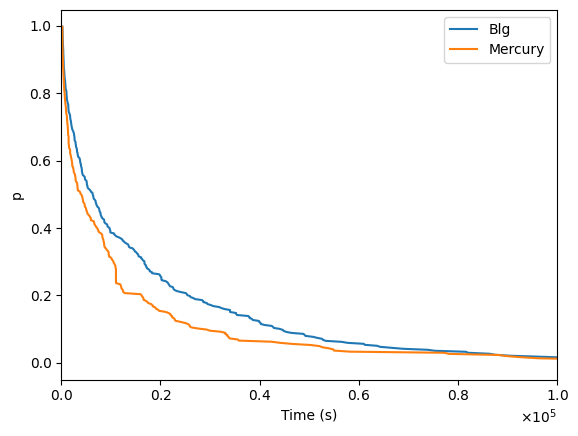

In [ ]:
#1)Plottaggio realibility Mercury & BluGene
interarrivals_list = [
    np.loadtxt('/content/BlgLog_interarrivals.txt'),
    np.loadtxt('/content/MercuryLog_interarrivals.txt')

]

labels_list = ['Blg', 'Mercury']

plotComp_empirical_ttf_reliability(interarrivals_list, labels=labels_list, xlim=(0, 1e5))

**There exist dependability-bottlenecks (i.e., topcontributors to the total number of failures)?**

Per quanto riguarda il supercalcolatore mercury, considerando il numero di
entries relativi al nodo tg-c401 ed al valore di reliability si può affermare che questo rappresenti un collo di bottiglia per il sistema in quanto è meno reliable del sistema ed ha molti fallimenti, la maggior parte di tutto il sistema.

Per quanto riguarda invece il supercalcolatore BGL, vediamo come il nodo
R03-M1-NF sia quello con la reliability più bassa quindi potrebbe essere lui
il collo di bottiglia.

**Do similar functional nodes (e.g., two Mercury tg-cX computing nodes or BG/L I/O nodes Ri:Mx:Nz) exhibit similar reliability parameters?**

Tra quelli più rilevanti osservati, sicuramente i nodi R71-M0-N4 ed R12-M0-N0 hanno una reliability simile tra di loro, come appunto esibisce il grafico.

**There exist a relationship between the error types and the node (Mercury)?**


Grazie allo script usato in precedenza, abbiamo visto come abbiamo potuto classificare per ogni nodo e per ogni categoria il numero di errori. La maggior parte degli errori appartengono alla categoria "DEV", ed in particolar modo al nodo tg-c401. D’altronde, avevamo già constatato che questo nodo rappresentava il collo di bottiglia del sistema. Anche per MEM, la maggior parte degli errori deriva dal nodo tg-401. OTH rappresenta una percentuale bassissima di errori, mentre per PRO il nodo tg-401 non ha errori. Possiamo dunque affermare una relazione tra il nodo tg-401 e gli errori di tipo DEV e MEM.

Analisi tipologia Errore:I-O
== Total error entries ==
5547
== Breakup by NODE* ==
['tg-s044 -> 3208', 'tg-master -> 452', 'tg-login3 -> 381', 'tg-s038 -> 230', 'tg-c550 -> 222', 'tg-login4 -> 148', 'tg-login1 -> 146', 'tg-login2 -> 145', 'tg-c685 -> 63', 'tg-c860 -> 61']
* only the top 10 most occurring nodes are reported


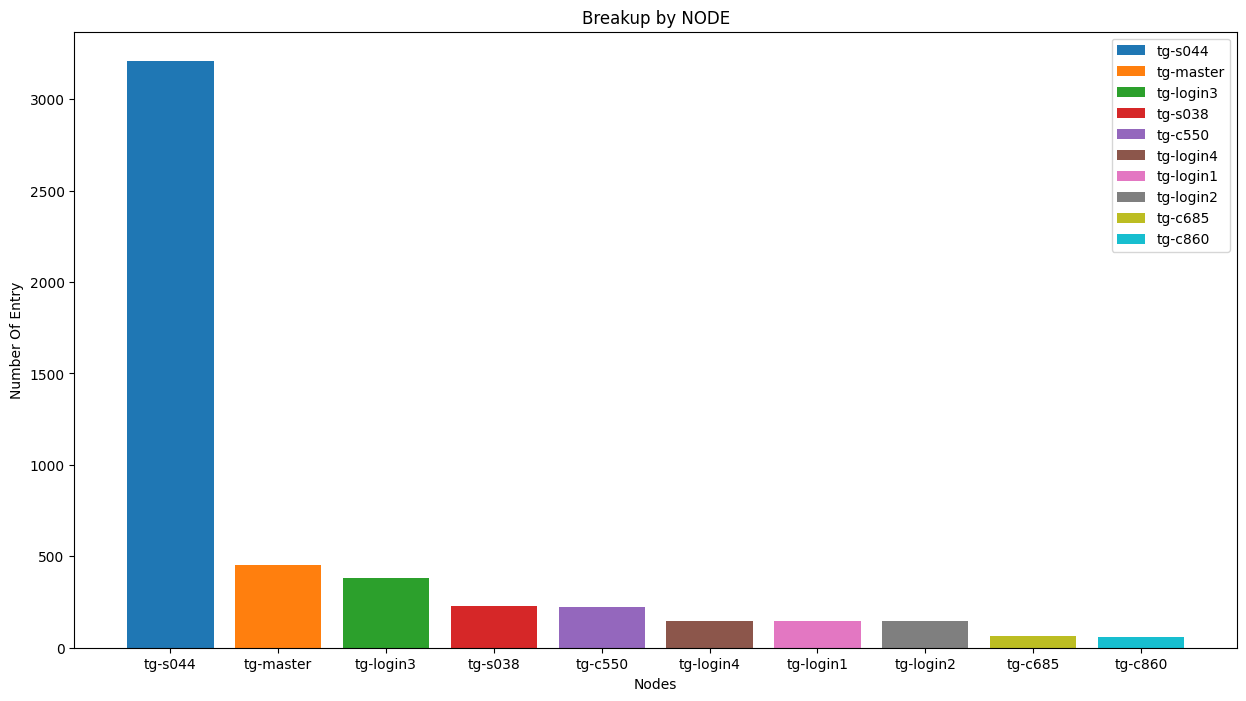

== Breakup by CATEGORY ==
['I-O -> 5547']
Analisi tipologia Errore:DEV
== Total error entries ==
57248
== Breakup by NODE* ==
['tg-c401 -> 50782', 'tg-c572 -> 3176', 'tg-c238 -> 1071', 'tg-c242 -> 918', 'tg-c117 -> 263', 'tg-c669 -> 257', 'tg-s176 -> 208', 'tg-c894 -> 187', 'tg-c781 -> 92', 'tg-c407 -> 83']
* only the top 10 most occurring nodes are reported


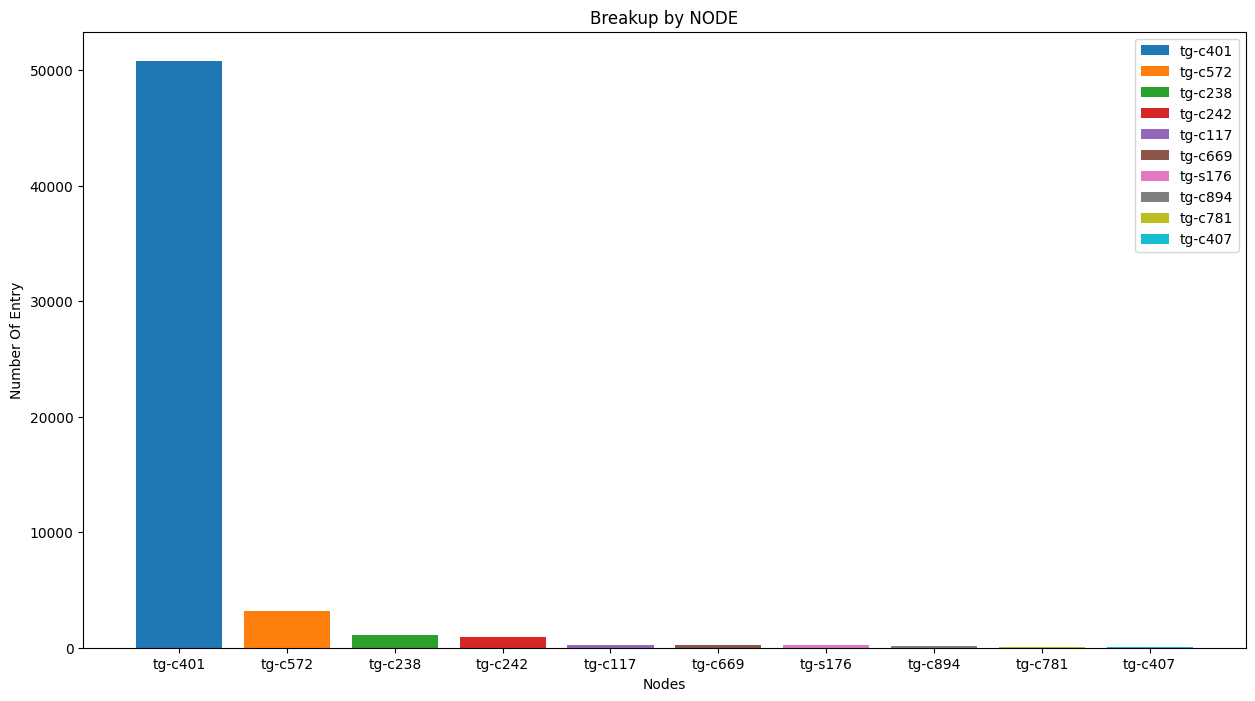

== Breakup by CATEGORY ==
['DEV -> 57248']
Analisi tipologia Errore:PRO
== Total error entries ==
1504
== Breakup by NODE* ==
['tg-c648 -> 616', 'tg-c324 -> 239', 'tg-c284 -> 180', 'tg-c451 -> 159', 'tg-c447 -> 136', 'tg-c415 -> 61', 'tg-c733 -> 28', 'tg-c027 -> 22', 'tg-c533 -> 18', 'tg-c416 -> 9']
* only the top 10 most occurring nodes are reported


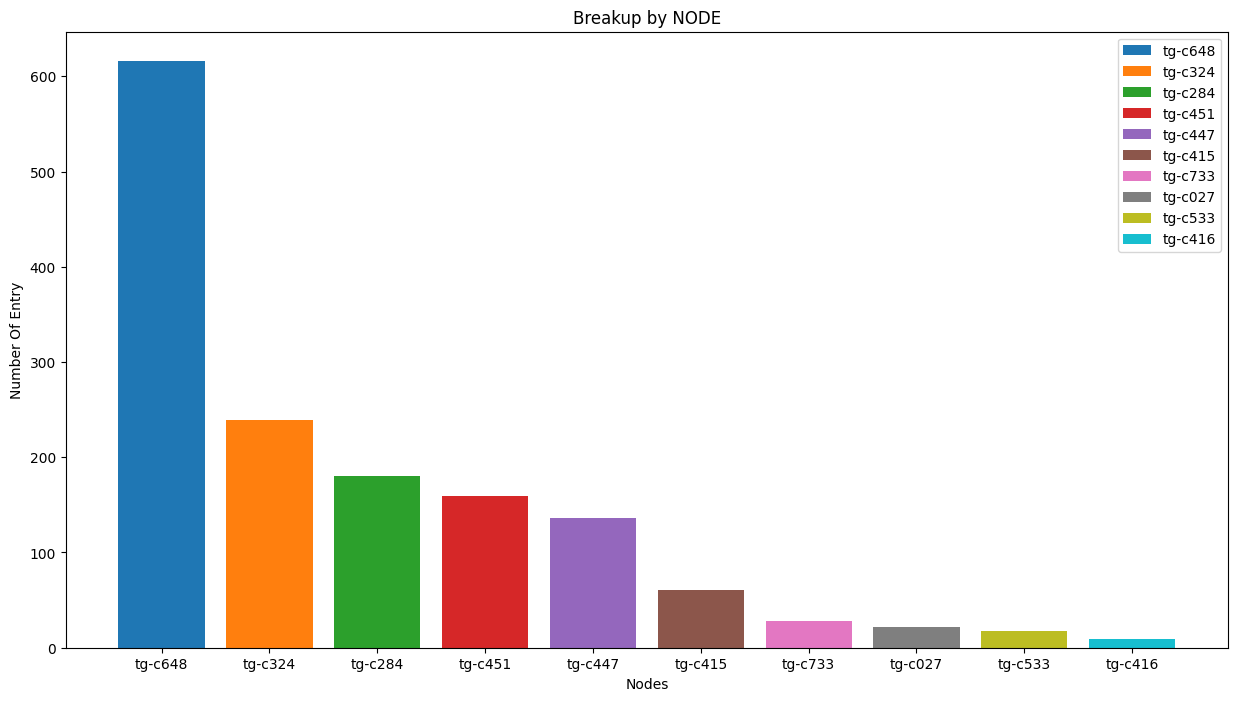

== Breakup by CATEGORY ==
['PRO -> 1504']
Analisi tipologia Errore:NET
== Total error entries ==
3702
== Breakup by NODE* ==
['tg-master -> 3639', 'tg-c550 -> 33', 'tg-c196 -> 14', 'tg-c238 -> 3', 'tg-c027 -> 2', 'tg-s044 -> 2', 'tg-login1 -> 1', 'tg-c128 -> 1', 'tg-login3 -> 1', 'tg-s131 -> 1']
* only the top 10 most occurring nodes are reported


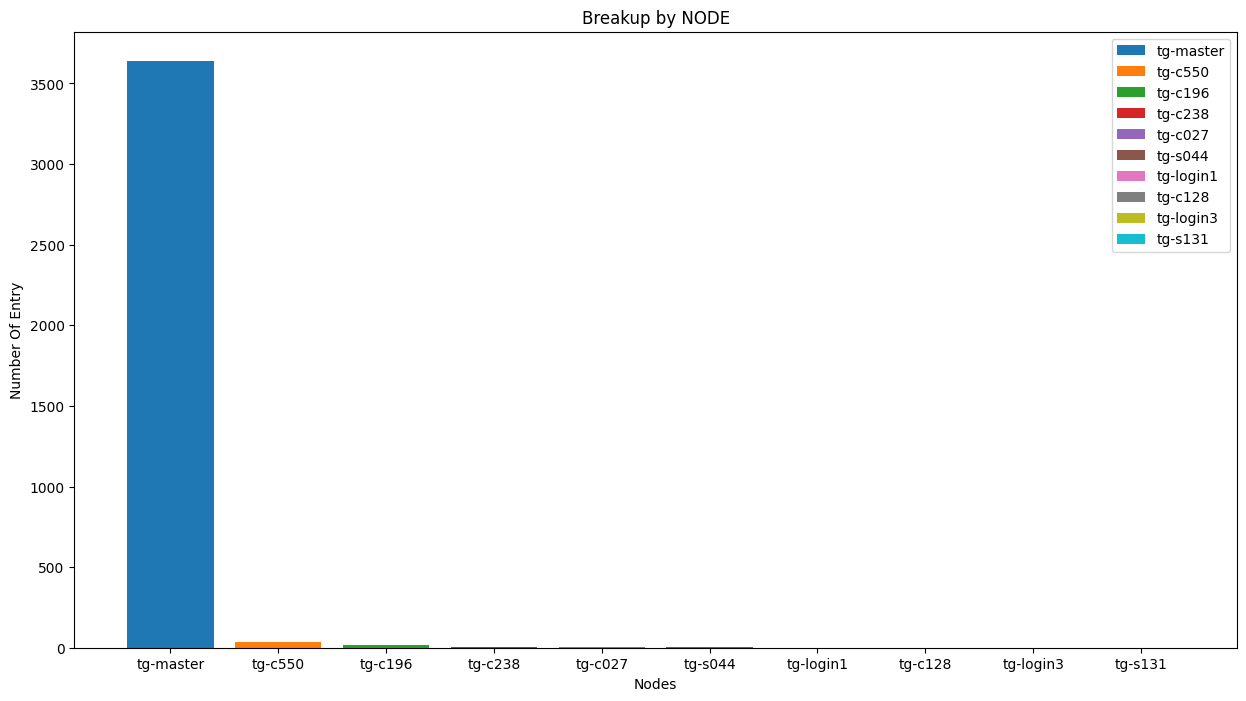

== Breakup by CATEGORY ==
['NET -> 3702']
Analisi tipologia Errore:MEM
== Total error entries ==
12819
== Breakup by NODE* ==
['tg-c401 -> 11558', 'tg-c572 -> 845', 'tg-c238 -> 197', 'tg-c242 -> 149', 'tg-c894 -> 28', 'tg-c407 -> 14', 'tg-c669 -> 10', 'tg-c735 -> 6', 'tg-c117 -> 5', 'tg-c757 -> 3']
* only the top 10 most occurring nodes are reported


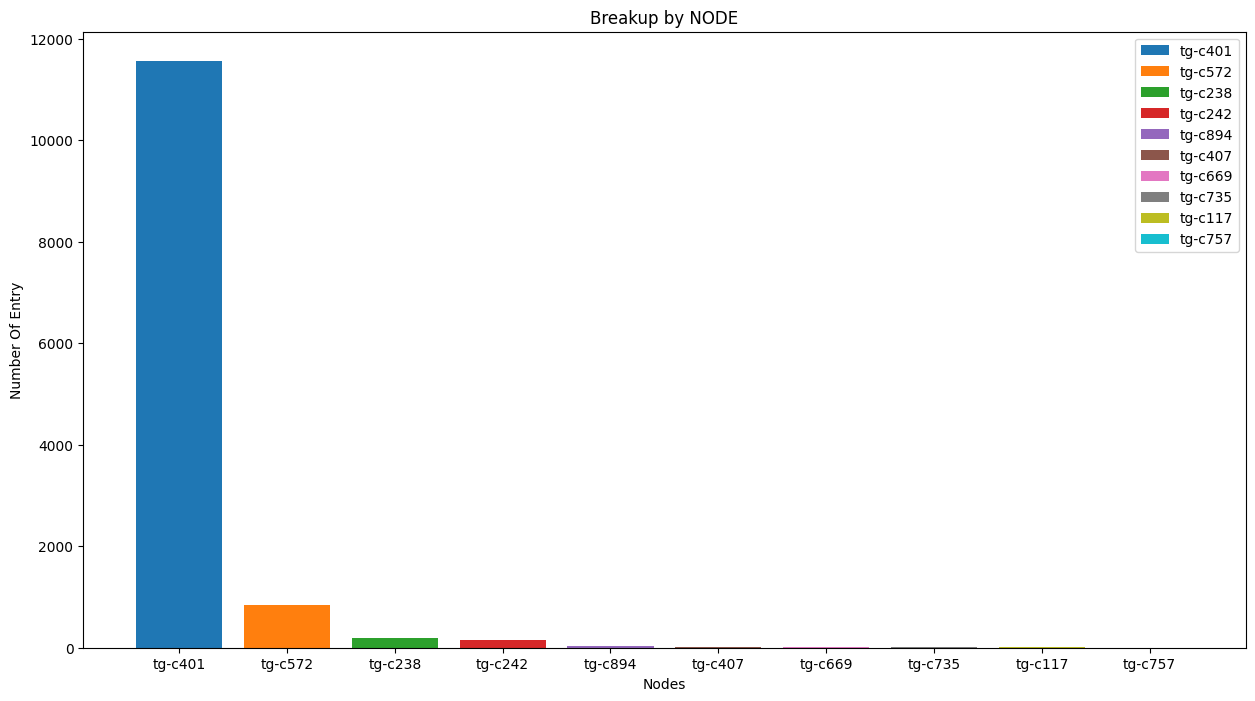

== Breakup by CATEGORY ==
['MEM -> 12819']
Analisi tipologia Errore:OTH
== Total error entries ==
34
== Breakup by NODE* ==
['tg-s044 -> 14', 'tg-master -> 3', 'tg-c894 -> 3', 'tg-c834 -> 3', 'tg-c733 -> 3', 'tg-c383 -> 2', 'tg-c860 -> 2', 'tg-c247 -> 2', 'tg-c324 -> 1', 'tg-c685 -> 1']
* only the top 10 most occurring nodes are reported


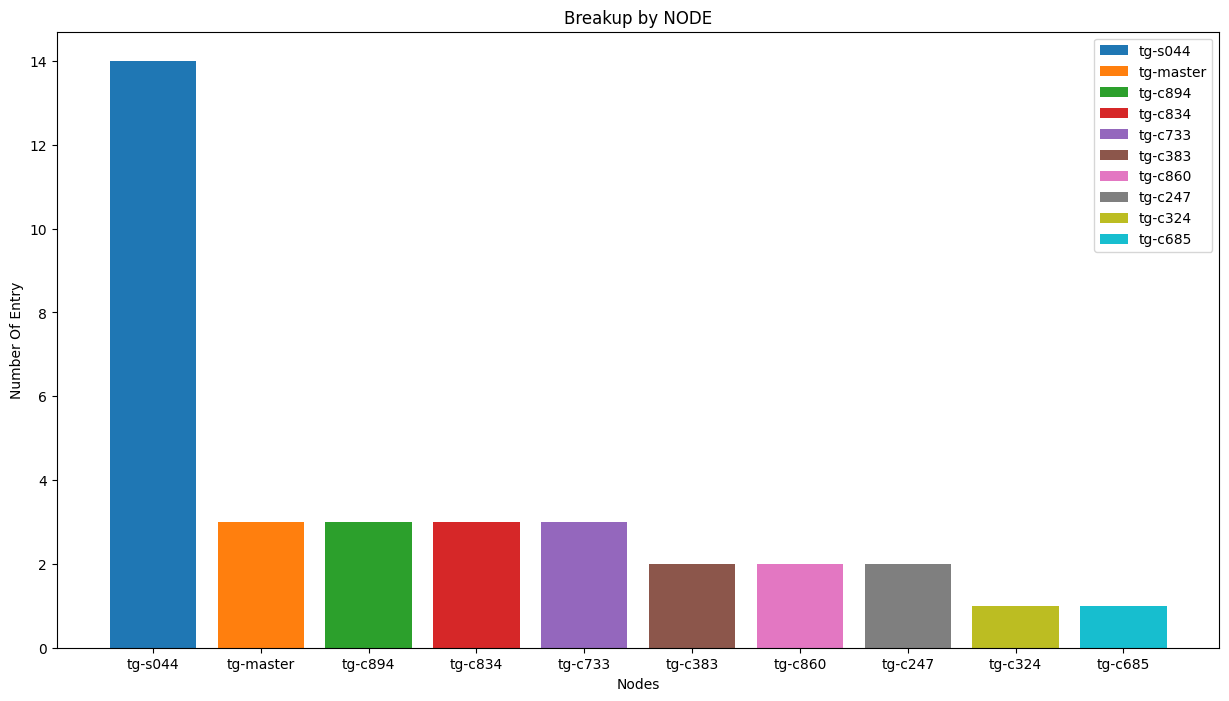

== Breakup by CATEGORY ==
['OTH -> 34']


In [ ]:
#Analisi sui singoli errori
#Cartella contenente i file di log
cartella_logs = "/content/DivisioneErroriMercury"

# Lista per contenere i percorsi dei file di log
logfile_path = []

# Itera su tutti i file nella cartella
for filename in os.listdir(cartella_logs):
      # Crea il percorso completo del file
      percorso_file = os.path.join(cartella_logs, filename)

      # Verifica se è un file (non una cartella)
      if os.path.isfile(percorso_file):
          # Aggiunge il percorso del file alla lista
          logfile_path.append(percorso_file)

for percorso in logfile_path:
    # Estrai il nome del file senza estensione

    testo_desiderato  = os.path.splitext(os.path.basename(percorso))[0]
    testo=testo_desiderato.split('_')[0]
    print("Analisi tipologia Errore:"+testo)

    statistics_log_file(percorso)